- **This code computes the decomposed solution of a Closed-Loop DRTO problem and implement both decomposed and monolithic strategies in a plant**
- Using economic objective function
- The underlying control structure (modeled in the CLDRTO model) is a constrained MPC, which is solved using MPCC
- The problem is posed as a scenario-based stochastic programming problem
- The case study is an affine multiple parallel bioreactor system from:*Gao, Ling. "Modeling and dynamics analyses of immobilized CSTR bioreactor using transfer function model." 2012 International Symposium on Information Technologies in Medicine and Education. Vol. 2. IEEE, 2012.*
- The uncertainty represented by the scenarios comes from the maximum specific growth rate (V_m) --> see matlab file

AUTHOR: Jose Matias <assumpcj@mcmaster.ca>
DATE: May 2023

In [1]:
using LinearAlgebra, JuMP, CPLEX, Ipopt, Plots, CSV, DataFrames, Random, Distributions, LaTeXStrings

# Simulation Configuration

In [2]:
# Sampling time
T = 1 #[h]

# Set seed value for choosing the plant parameter 
seed = 42
Random.seed!(seed)

# Number of manipulated inputs
nu = 1
# Number of controlled outputs
ny = 1

# setting bounds (all arbitrary - not in deviation form!!) 
uMax = 5.0 # for tight constraints: 1.9 | for loose constraints: 5.0 or 10.0
uMin = 0.0

yspMax = 1.2 
yspMin = 0.0;

# Building affine CL-DRTO models

In [3]:
# Linearization point
u0 = 1.5
x0 = [0.7179;0.7821]
y0 = 0.7821

# 100 pre-computed models based on parametric uncertainty Vm (computed using matlab: BioReactorLinearization.m)
bioModels = CSV.read("C:\\Users\\MACC-Jose\\Documents\\GitHub\\BD\\CLDRTO Case Study 2 - Bioreactor\\BioreactorModel", DataFrame; header=false);
#print(bioModels)

# CL-DRTO configuration

In [4]:
# DRTO sampling time
nDRTO = 4 # [h]
# Prediction horizon
pD = 20 + (8 - 1)# p = 8 *controller horizon  
# Input control horizon 
mD = 20
# Objective function: target tracking (deviation form)
pTrack = 1 - y0 # [g/L]
# Soft upper bounds on P weight (deviation form)
pUB = 1.05 - y0 # [g/L]
# objective function weight for P penalization term 
wP = 100;

# MPC configuration

In [5]:
# MPC sampling time
nMPC = 1 # [h]

# Controller configuration
# Output prediction horizon
p = 8
# Input control horizon 
m = 2
# Output weights
q = 1
# Input weights 
r = 1;

# Bender's configuration

In [6]:
# max number of iteration
benIterMax = 200

# optimality gap (relative) tolerance
optGap = 1e-3; # MPCC: 0.5 / 1e-3

# Auxiliary functions

- DRTO model changes with the number of scenarios and parallel reactors.  

Used for the monolithic solution. Generates an array of models. Several different models were already computed offline and saved in the "bioModel" array. This function extracts the models based on a fixed index grid that is generated based on the number of scenarios

In [7]:
function DRTO_matrices(nReactors,nScenarios)
    ###########
    # inputs: #
    ###########
    # nReactors - number of reactors in parallel
    # nScenarios - number of scenarios used in the stochastic optimization
    
    # set dimensions
    nx = 2*nReactors
    # SISO system
    ny = 1
    nu = 1
    
    # picking up indexes equally spaced between 1 and 100 (including initial and end point) 
    # based on the desired number of scenarios
    if nScenarios == 1
        indexScen = 50 # nominal model --> index = 50
    else
        indexScen = [floor(Int, 1 + (ii - 1)*(100-1)/(nScenarios-1)) for ii in 1:nScenarios]
    end
    
    # building DRTO model
    A_drto = Array{Float64}(undef,nx,nx,nScenarios) 
    B_drto = Array{Float64}(undef,nx,nu,nScenarios) 

    for kk in 1:nScenarios

        index_temp = indexScen[kk]

        A_drto[:,:,kk] = kron(I(nReactors),Matrix(bioModels[2*(index_temp - 1) + 1:2*(index_temp - 1) + 2,1:2]))
        B_drto[:,:,kk] = repeat(bioModels[2*(index_temp - 1) + 1:2*(index_temp - 1) + 2,3], outer = [nReactors, 1, 1])

    end

    # mapping states to measurements is the same for all models
    C_drto = repeat([0 1], outer = [1, nReactors])
    
    return Dict('A' => A_drto, 'B' => B_drto, 'C' => C_drto)
end;

- DRTO model changes with the number of scenarios and parallel reactors.  

Used for the decomposed solution. Generates a single model. Several different models were already computed offline and saved in the "bioModel" array. This function extracts the model of interest based on the index "nScenario"

In [8]:
function DRTO_matrix(nReactors,nScenario,nScenTotal)  
    ###########
    # inputs: #
    ###########
    # nReactors - number of reactors in parallel
    # nScenario - index the of scenario used in the stochastic optimization
    # nScenTotal - total number of scenario used in the stochastic optimization
    
    # set dimensions
    nx = 2*nReactors
    # SISO system
    ny = 1
    nu = 1
    
    if nScenTotal == 1
        index_temp = 50 # nominal model --> index = 50
    else
        indexScen = [floor(Int, 1 + (ii - 1)*(100-1)/(nScenTotal-1)) for ii in 1:nScenTotal]
        index_temp = indexScen[nScenario]
    end
  
    # building DRTO model
    A_drto = kron(I(nReactors),Matrix(bioModels[2*(index_temp - 1) + 1:2*(index_temp - 1) + 2,1:2]))
    B_drto = repeat(bioModels[2*(index_temp - 1) + 1:2*(index_temp - 1) + 2,3], outer = [nReactors, 1, 1])

    # mapping states to measurements is the same for all models
    C_drto = repeat([0 1], outer = [1, nReactors]);
    
    return Dict('A' => A_drto, 'B' => B_drto, 'C' => C_drto)
end;

- Building MPC Model

Using nominal model(indexScen = 50). For the description of how the MPC matrices (with disturbance model) are built, check script: *CLDRTO with unconstrained MPC - uncertain plant test*

In [9]:
function MPC_matrices(nReactors)
    ###########
    # inputs: #
    ###########
    # nReactors - number of reactors in parallel
    
    # set dimensions
    nx = 2*nReactors
    # SISO system
    ny = 1
    nu = 1
    
    # extracting the matrices from the model array computed previously
    nNom = 50 # nominal model --> index = 50
    
    A = kron(I(nReactors),Matrix(bioModels[2*(nNom - 1) + 1:2*(nNom - 1) + 2,1:2])) 
    B = repeat(bioModels[2*(nNom - 1) + 1:2*(nNom - 1) + 2,3], outer = [nReactors, 1])
    C = repeat([0 1], outer = [1, nReactors])
    
    # adding disturbance model
    Ad = [A zeros(nx,ny); zeros(ny,nx) I(ny)]
    Bd = [B; zeros(ny,nu)]
    Cd = [C ones(ny,ny)]
    
    # building matrices for MPC
    Psi = Cd*Ad
    for ii in 2:p
        Psi = [Psi;  Cd*Ad^ii]
    end

    # Computing Dynamic Matrix
    a = Cd*Bd
    for ii in 2:p
        a = [a; Cd*Ad^(ii - 1)*Bd]
    end
    DynM = a

    for ii in 1:(m - 2)
        a = [zeros(ny,nu);a[1:(p-1)*ny,:]]
        DynM = [DynM  a]
    end

    # adjusting dynamic matrix for since p > m (last column)
    b = Cd*Bd

    Ai = I(nx+1) # adding disturbance to the states
    for ii = 1:(p - m)
        Ai = Ai + Ad^ii
        b = [b;Cd*Ai*Bd]
    end

    Theta=[DynM [zeros(ny*(m-1),nu);b]]
    
    # Creating Qbar and Rbar matrices
    Qbar = Diagonal([q for ii in 1:p])
    Rbar = Diagonal([r for ii in 1:m])

    # Creating input movement OF penalty matrix 
    M=[zeros((m-1)*nu,nu) I(nu*(m-1)); zeros(nu) zeros(nu,nu*(m-1))]
    Ibar=[I(nu); zeros(nu*(m-1),nu)]
    IM = I(nu*m) - M';
    
    # Matrix H
    H = Theta'*Qbar*Theta + IM'*Rbar*IM;
    
    return Dict('A' => A, 'B' => B, 'C' => C, 'H' => H, 'Θ' => Theta, 'Ψ' => Psi, 'Q' => Qbar, 'I' => Ibar, 'R' => Rbar, 'M' => IM)
end;

- Building function for computing MPC solution (solving QP)

In [10]:
function solveMPC(xkk,dekk,uk_1,yspk,uref,umin,umax,p,m,nReac)
    ###########
    # inputs: #
    ###########
    # xkk - current states (MPC model) 
    # dekk - disturbance estimate 
    # uk_1 - inputs at the current iteration, already implemented on the plant
    # yspk - setpoint trajectory computed by CL-DRTO
    # uref - input reference value
    # umin, umax - input bounds
    # p, m - prediction and control horizon
    # nReac - number of parallel reactors
    
    # Creating MPC matrices
    mpc = MPC_matrices(nReac)
    
    MPC_con = Model(Ipopt.Optimizer)
    set_silent(MPC_con)
    
    ####################
    # Set up variables #
    ####################
    # inputs computed by MPCs
    @variable(MPC_con, (umin - uref) ≤ u[1:m] ≤ (umax - uref) )
    
    ######################################
    # Set up constraints and expressions #
    ######################################
    # for OF computation
    @expression(MPC_con, cfT, (mpc['Ψ']*[xkk;dekk] - yspk)'*mpc['Q']*mpc['Θ'] - uk_1'*mpc['I']'*mpc['R']*mpc['M'])
        
    #############################
    # Set up objective function #
    #############################
    @objective(MPC_con, Min, sum(u[jj]*sum(mpc['H'][jj,ii]*u[ii] for ii in 1:m) for jj in 1:m) + 2*sum(cfT[jj]*u[jj] for jj = 1:m))
    # @show MPC_con

    #################
    # Solve Problem #
    #################
    optimize!(MPC_con)

    #calling values of the solved problem
    ϕ = objective_value(MPC_con)
    uArray = value.(u)

    return Dict('ϕ' => ϕ,'u' => uArray)
end;

# Solving CL-DRTO Multiscenario Problem (monolithic)
 - Check details in script *Monolithic CLDRTO*
 - For the description of the different solution strategies, check *Different Strategies to solve constrained MPC within CLDRTO*

In [11]:
# Parameters for MPC solution
# matrix to compute the gradients of the input bound constraints
conMatrix = [I(m); -I(m)]; 

# big-M implementation
bigM_mu = 1000
bigM_u = 100

# weight complementarity relaxation OF term
pi_bar = 10^3;

In [12]:
## Modeling the sub problem (scenario) -- modeling inside a function
function MS_CLDRTO(xInit,uInit,nReac,nScen,pScen,solNom,option)
    ###########
    # inputs: #
    ###########
    # xInit - states at the current iteration (beginning of DRTO horizon)
    # uInit - inputs at the current iteration, already implemented on the plant
    # nReac - number of parallel reactors
    # nScen - number of scenarios used in the problem (only one branching)
    # pScen - probability of the scenarios
    # solNom - nominal solution
    # option - strategy for solving MPC

    # Creating MPC matrices
    mpc = MPC_matrices(nReac)
    
    # Creating DRTO matrices
    drto = DRTO_matrices(nReac,nScen)

    # Define model
    if option == 3 || option == 1
        model_ms = Model(Ipopt.Optimizer)
        set_optimizer_attribute(model_ms, "max_cpu_time", 300.0) # 5 min
    else 
        model_ms = Model(CPLEX.Optimizer)
        set_optimizer_attribute(model_ms, "CPX_PARAM_TILIM", 300.0) # 5 min
    end
    set_silent(model_ms)
    
    ####################
    # Set up variables #
    ####################
    # DRTO model variables
    @variable(model_ms, xDRTO[1:pD,1:nx,1:nScen])
    @variable(model_ms, yDRTO[1:pD,1:nScen])
    
    # MPC model variables
    @variable(model_ms, xMPC[1:pD,1:nx,1:nScen])
    @variable(model_ms, yMPC[1:pD,1:nScen])
    
    # MPC <-> DRTO model deviation
    @variable(model_ms, de[1:pD,1:nScen])
    
    # inputs computed by MPCs
    @variable(model_ms, u[1:pD,1:m,1:nScen])
    if option == 1
        @variable(model_ms, u_w_c[1:pD,1:m,1:nScen]) # inputs w/o clipping
    
        # input clipping 
        @variable(model_ms, mu_lb[1:pD,1:m,1:nScen] ≥ 0)
        @variable(model_ms, eta_lb[1:pD,1:m,1:nScen] ≥ 0)
        @variable(model_ms, mu_ub[1:pD,1:m,1:nScen] ≥ 0)
        @variable(model_ms, eta_ub[1:pD,1:m,1:nScen] ≥ 0)       
    end
    
    # setpoints for the controllers sent to the plant (CL-DRTO degrees of freedom)
    @variable(model_ms, (yspMin - y0) ≤ ysp[1:pD,1:nScen] ≤ (yspMax - y0))
    
    # slacks for P soft constraint
    @variable(model_ms, delta_p[1:pD,1:nScen] ≥ 0)
    
    if option == 2 || option == 3
        @variable(model_ms, mu_g[1:mD,1:(2*m),1:nScen] ≥ 0) # upper and lower bounds for each input
    end
    if option == 2
        @variable(model_ms, Y_lb[1:mD,1:m,1:nScen], Bin, start = 0) # Binaries for big-M implementation
        @variable(model_ms, Y_ub[1:mD,1:m,1:nScen], Bin, start = 0) 
    end
    
    ########################
    # Set up initial guess #
    ########################
    if solNom isa Dict
        for ss in 1:nScen
            for ii in 1:pD
                set_start_value(yDRTO[ii,ss], solNom['y'][ii,1]) 
                set_start_value(yMPC[ii,ss], solNom['c'][ii,1])
                set_start_value(ysp[ii,ss], solNom['s'][ii,1])

                for rr in 1:nReac # when nReac increases, the number of states change!
                    for xx in 1:2 # N.B. nx/reactor is hardcoded here... (maybe use nx/reactor as a function input) 
                        set_start_value(xDRTO[ii,xx + (rr - 1)*2,ss], solNom['x'][ii,xx,1])    
                        set_start_value(xMPC[ii,xx + (rr - 1)*2,ss], solNom['m'][ii,xx,1])           
                    end # end xx
                end # number 
                
                for uu in 1:m
                    set_start_value(u[ii,uu,ss], solNom['u'][ii,uu,1])
                end # end of uu
            end # eend of ii
        end # end of ss
    end # end of if
    
    ######################################
    # Set up constraints and expressions #
    ######################################
    # Model Dynamic for Dynamic RTO
    @constraint(model_ms, CLDRTO_dyn_model_1[ss=1:nScen], xDRTO[1,:,ss] .== drto['A'][:,:,ss]*xInit + drto['B'][:,:,ss]*uInit)
    @constraint(model_ms, CLDRTO_dyn_model[kk=1:(pD - 1),ss=1:nScen], xDRTO[kk + 1,:,ss] .== drto['A'][:,:,ss]*xDRTO[kk,:,ss] + drto['B'][:,:,ss]*u[kk,1,ss])
    @constraint(model_ms, CLDRTO_model_out[kk=1:pD,ss=1:nScen], yDRTO[kk,ss] == dot(drto['C'],xDRTO[kk,:,ss]))
    
    # fixing setpoint changes after mD
    @constraint(model_ms, control_horizon[kk=(mD+1):pD,ss=1:nScen], u[kk,1,ss] .== u[mD,1,ss])
    
    # P soft constraints
    @constraint(model_ms, soft_P[kk=1:pD,ss=1:nScen], yDRTO[kk,ss] - delta_p[kk,ss] ≤ pUB)
    
    # nonanticipativity constraints
    @constraint(model_ms, nonAnt[kk=1:nDRTO,ss=2:nScen], ysp[kk,1] - ysp[kk,ss] == 0.0);
    
    ################
    # MPC solution #
    ################    
    if option == 1
        # Model Dynamic for Controller
        @constraint(model_ms, MPC_dyn_model_1[ss=1:nScen], xMPC[1,:,ss] .== mpc['A']*xInit + mpc['B']*uInit)
        @constraint(model_ms, MPC_dyn_model[kk=1:(pD - 1),ss=1:nScen], xMPC[kk + 1,:,ss] .== mpc['A']*xMPC[kk,:,ss] + mpc['B']*u_w_c[kk,1,ss])
        @constraint(model_ms, MPC_model_out[kk=1:pD,ss=1:nScen], yMPC[kk,ss] == dot(mpc['C'],xMPC[kk,:,ss]))

        #  Model deviation
        @constraint(model_ms, MPC_model_dev[kk=1:pD,ss=1:nScen], de[kk,ss] == yDRTO[kk,ss] - yMPC[kk,ss])
        
        @expression(model_ms, cfT_1[ss=1:nScen], (mpc['Ψ']*[xMPC[1,:,ss];de[1,ss]] - ysp[1:p,ss])'*mpc['Q']*mpc['Θ'] - uInit'*mpc['I']'*mpc['R']*mpc['M'])
        @expression(model_ms, cfT[kk=2:mD,ss=1:nScen], (mpc['Ψ']*[xMPC[kk,:,ss];de[kk,ss]] - ysp[kk:(kk + p - 1),ss])'*mpc['Q']*mpc['Θ'] - u_w_c[kk-1,1,ss]'*mpc['I']'*mpc['R']*mpc['M'])
        
        # Unconstrained MPC solution  
        @constraint(model_ms, MPC_sol_1[ss=1:nScen], mpc['H']*u_w_c[1,:,ss] + cfT_1[ss]' .== 0)
        @constraint(model_ms, MPC_sol[kk=2:mD,ss=1:nScen], mpc['H']*u_w_c[kk,:,ss] + cfT[kk,ss]' .== 0)
        
        # input clipping
        @constraint(model_ms, ic_1[kk = 1:mD,uu = 1:m,ss = 1:nScen], u[kk,uu,ss] == u_w_c[kk,uu,ss] - mu_ub[kk,uu,ss] + mu_lb[kk,uu,ss])
        @constraint(model_ms, ic_2[kk = 1:mD,uu = 1:m,ss = 1:nScen], (uMax - u0) - u[kk,uu,ss] == eta_ub[kk,uu,ss])
        @constraint(model_ms, ic_3[kk = 1:mD,uu = 1:m,ss = 1:nScen], eta_ub[kk,uu,ss]*mu_ub[kk,uu,ss] ≤ 1e-6)
        @constraint(model_ms, ic_4[kk = 1:mD,uu = 1:m,ss = 1:nScen], u[kk,uu,ss] - (uMin - u0) == eta_lb[kk,uu,ss])
        @constraint(model_ms, ic_5[kk = 1:mD,uu = 1:m,ss = 1:nScen], eta_lb[kk,uu,ss]*mu_lb[kk,uu,ss] ≤ 1e-6)
        
    elseif option == 2
        # Model Dynamic for Controller
        @constraint(model_ms, MPC_dyn_model_1[ss=1:nScen], xMPC[1,:,ss] .== mpc['A']*xInit + mpc['B']*uInit)
        @constraint(model_ms, MPC_dyn_model[kk=1:(pD - 1),ss=1:nScen], xMPC[kk + 1,:,ss] .== mpc['A']*xMPC[kk,:,ss] + mpc['B']*u[kk,1,ss])
        @constraint(model_ms, MPC_model_out[kk=1:pD,ss=1:nScen], yMPC[kk,ss] == dot(mpc['C'],xMPC[kk,:,ss]))

        #  Model deviation
        @constraint(model_ms, MPC_model_dev[kk=1:pD,ss=1:nScen], de[kk,ss] == yDRTO[kk,ss] - yMPC[kk,ss])

        # sequence of Setpoints
        @expression(model_ms, cfT_1[ss=1:nScen], (mpc['Ψ']*[xMPC[1,:,ss];de[1,ss]] - ysp[1:p,ss])'*mpc['Q']*mpc['Θ'] - uInit'*mpc['I']'*mpc['R']*mpc['M'])
        @expression(model_ms, cfT[kk=2:mD,ss=1:nScen], (mpc['Ψ']*[xMPC[kk,:,ss];de[kk,ss]] - ysp[kk:(kk + p - 1),ss])'*mpc['Q']*mpc['Θ'] - u[kk-1,1,ss]'*mpc['I']'*mpc['R']*mpc['M'])

        # Constrained with binaries
        # 1. stationarity
        @constraint(model_ms, MPC_sol_1[ss=1:nScen], u[1,:,ss]'*mpc['H'] + cfT_1[ss] +  mu_g[1,:,ss]'*conMatrix .== 0)
        @constraint(model_ms, MPC_sol[kk=2:mD,ss=1:nScen], u[kk,:,ss]'*mpc['H'] + cfT[kk,ss] + mu_g[kk,:,ss]'*conMatrix .== 0)

        # 2. primal feasibility
        @constraint(model_ms, g_u_u[kk=1:mD,uu=1:m,ss=1:nScen], u[kk,uu,ss] - (uMax - u0) ≤ 0)
        @constraint(model_ms, g_u_l[kk=1:mD,uu=1:m,ss=1:nScen], (uMin - u0) - u[kk,uu,ss] ≤ 0)
    
        # 3. complementarity --> using big-M implementation
        @constraint(model_ms, bigM_1[kk=1:mD,uu=1:m,ss=1:nScen], mu_g[kk,uu,ss] ≤ bigM_mu*Y_ub[kk,uu,ss])
        @constraint(model_ms, bigM_2[kk=1:mD,uu=1:m,ss=1:nScen], mu_g[kk,uu + m,ss] ≤ bigM_mu*Y_lb[kk,uu,ss])
        @constraint(model_ms, bigM_3[kk=1:mD,uu=1:m,ss=1:nScen], u[kk,uu,ss] - (uMax - u0) ≥ -bigM_u*(1 - Y_ub[kk,uu,ss]))
        @constraint(model_ms, bigM_4[kk=1:mD,uu=1:m,ss=1:nScen], (uMin - u0) - u[kk,uu,ss] ≥ -bigM_u*(1 - Y_lb[kk,uu,ss]))
        
        @constraint(model_ms, compSlack[kk=1:mD,uu=1:m,ss=1:nScen], Y_ub[kk,uu,ss] + Y_lb[kk,uu,ss] ≤ 1)
    
    elseif option == 3
        # Model Dynamic for Controller
        @constraint(model_ms, MPC_dyn_model_1[ss=1:nScen], xMPC[1,:,ss] .== mpc['A']*xInit + mpc['B']*uInit)
        @constraint(model_ms, MPC_dyn_model[kk=1:(pD - 1),ss=1:nScen], xMPC[kk + 1,:,ss] .== mpc['A']*xMPC[kk,:,ss] + mpc['B']*u[kk,1,ss])
        @constraint(model_ms, MPC_model_out[kk=1:pD,ss=1:nScen], yMPC[kk,ss] == dot(mpc['C'],xMPC[kk,:,ss]))

        #  Model deviation
        @constraint(model_ms, MPC_model_dev[kk=1:pD,ss=1:nScen], de[kk,ss] == yDRTO[kk,ss] - yMPC[kk,ss])

        # sequence of Setpoints
        @expression(model_ms, cfT_1[ss=1:nScen], (mpc['Ψ']*[xMPC[1,:,ss];de[1,ss]] - ysp[1:p,ss])'*mpc['Q']*mpc['Θ'] - uInit'*mpc['I']'*mpc['R']*mpc['M'])
        @expression(model_ms, cfT[kk=2:mD,ss=1:nScen], (mpc['Ψ']*[xMPC[kk,:,ss];de[kk,ss]] - ysp[kk:(kk + p - 1),ss])'*mpc['Q']*mpc['Θ'] - u[kk-1,1,ss]'*mpc['I']'*mpc['R']*mpc['M'])

        # Constrained with MPCC
        # 1. stationarity
        @constraint(model_ms, MPC_sol_1[ss=1:nScen], u[1,:,ss]'*mpc['H'] + cfT_1[ss] +  mu_g[1,:,ss]'*conMatrix .== 0)
        @constraint(model_ms, MPC_sol[kk=2:mD,ss=1:nScen], u[kk,:,ss]'*mpc['H'] + cfT[kk,ss] + mu_g[kk,:,ss]'*conMatrix .== 0)

        # 2. primal feasibility
        @constraint(model_ms, MPC_c_upper[kk=1:mD,uu=1:m,ss=1:nScen], u[kk,uu,ss] - (uMax - u0) ≤ 0)
        @constraint(model_ms, MPC_c_lower[kk=1:mD,uu=1:m,ss=1:nScen], (uMin - u0) - u[kk,uu,ss] ≤ 0)
        
        # Expressions for OF
        @expression(model_ms, g_u_u[kk=1:mD,uu=1:m,ss=1:nScen], u[kk,uu,ss] - (uMax - u0))
        @expression(model_ms, g_u_l[kk=1:mD,uu=1:m,ss=1:nScen], (uMin - u0) - u[kk,uu,ss])
        
    end
        
    #############################
    # Set up objective function #
    #############################
    if option == 1 || option == 2
        @objective(model_ms, Min, 
            pScen*sum(-yDRTO[kk,ss] + wP*delta_p[kk,ss]^2 for kk in 1:pD, ss in 1:nScen)
        )
    else
        @objective(model_ms, Min, pScen*sum(-yDRTO[kk,ss] + wP*delta_p[kk,ss]^2 for kk in 1:pD, ss in 1:nScen)
                                - pScen*pi_bar*sum(
                                                sum(mu_g[kk,jj,ss]*g_u_u[kk,jj,ss] for jj = 1:m) +
                                                sum(mu_g[kk,jj + m,ss]*g_u_l[kk,jj,ss] for jj = 1:m)
                                                for kk = 1:mD, ss in 1:nScen)
        )
    end
    # @show model_ms

    #################
    # Solve Problem #
    #################
    #set_optimizer_attribute(model_ms, "CPX_PARAM_BARALG", 1)
    optimize!(model_ms)
    
    status = termination_status(model_ms)
    #display(status)
    
    if status == MOI.OPTIMAL || status == MOI.ALMOST_OPTIMAL || status == MOI.LOCALLY_SOLVED
        # Proved optimality or Optimal within relaxed tolerances
        # solution time
        timeSol = solve_time(model_ms)

        flag = 1
        # #primal_status(m)

        #calling values of the solved problem
        ϕ = objective_value(model_ms)
        uArray = value.(u)
        yspArray = value.(ysp)
        yDRTOArray = value.(yDRTO)
        yMPCArray = value.(yMPC)
        xDRTOArray = value.(xDRTO)
        xMPCArray = value.(xMPC)

        outputFun = Dict('ϕ' => ϕ,
                        't' => timeSol,
                        'f' => flag, 
                        'u' => uArray,
                        's' => yspArray,
                        'x' => xDRTOArray,
                        'y' => yDRTOArray, 
                        'm' => xDRTOArray,
                        'c' => yDRTOArray)
        
        if option == 2 || option == 3
            muArray = value.(mu_g)
            merge!(outputFun,Dict('μ'=> muArray))
        end
        
        return outputFun
    else
        # Handle other cases.
        outputFun = Dict('f' => 0,
                         't' => NaN,
                         'ϕ' => NaN)
                        
        
        return outputFun
    end
end;

# Decomposition of CLDRTO Problem

- Modeling Subproblem

In [13]:
## Modeling the sub problem (scenario) -- modeling inside a function
function subp(xInit,uInit,ysp_fixed,nReac,nScen,pScen,solNom,option)
    ###########
    # inputs: #
    ###########
    # xInit - states at the current iteration (beginning of DRTO horizon)
    # uInit - inputs at the current iteration, already implemented on the plant
    # ysp_fixed - setpoints fixed by the Master Problem --> nonanticipativity constraints
    # nReac - number of parallel reactors
    # nScen - number of scenarios used in the problem (only one branching)
    # pScen - probability of the scenarios
    # solNom - nominal solution
    # option - strategy for solving MPC 
        # for now, code only works for option = 3

    # Creating MPC matrices
    mpc = MPC_matrices(nReac)
    
    # Creating DRTO matrices
    
    # recomputing the number of total scenarios based on scenario probability and the fact that the scenarios have the same probability
    nScenTotal = ceil(Int,1/pScen)    
    drto = DRTO_matrix(nReac,nScen,nScenTotal)
    
    # Define subproblem model  #== 3
    if option == 3 || option == 1
        sub = Model(Ipopt.Optimizer)
        set_optimizer_attribute(sub, "max_cpu_time", 300.0) # 5 min
    else 
        sub = Model(CPLEX.Optimizer)
        set_optimizer_attribute(sub, "CPX_PARAM_TILIM", 300.0) # 5 min
    end
    set_silent(sub) # avoid printing
    
    ####################
    # Set up variables #
    ####################
    # DRTO model variables
    @variable(sub, xDRTO[1:pD, 1:nx])
    @variable(sub, yDRTO[1:pD])
    
    # MPC model variables
    @variable(sub, xMPC[1:pD, 1:nx])
    @variable(sub, yMPC[1:pD])

    # MPC <-> DRTO model deviation
    @variable(sub, de[1:pD])
    
    # inputs computed by MPCs
    @variable(sub, u[1:pD,1:m])
    if option == 1
        @variable(sub, u_w_c[1:pD,1:m]) # inputs w/o clipping
    
        # input clipping 
        @variable(sub, mu_lb[1:pD,1:m] ≥ 0)
        @variable(sub, eta_lb[1:pD,1:m] ≥ 0)
        @variable(sub, mu_ub[1:pD,1:m] ≥ 0)
        @variable(sub, eta_ub[1:pD,1:m] ≥ 0)       
    end
    
    # setpoints for the controllers sent to the plant (CL-DRTO degrees of freedom)
    @variable(sub, (yspMin - y0) ≤ ysp[1:pD] ≤ (yspMax - y0))
        
    # slacks for controlling setpoint into a zone
    @variable(sub, delta_p[1:pD] ≥ 0)
    
    if option == 2 || option == 3
        @variable(sub, mu_g[1:mD,1:(2*m)] ≥ 0) # upper and lower bounds for each input
    end
    if option == 2
        @variable(sub, Y_lb[1:mD,1:m], start = 0) # Relaxing binaries for big-M implementation
        @variable(sub, Y_ub[1:mD,1:m], start = 0) 
    end
    
    ########################
    # Set up initial guess #
    ########################
    if solNom isa Dict
        for ii in 1:pD
            set_start_value(yDRTO[ii], solNom['y'][ii,1]) 
            set_start_value(yMPC[ii], solNom['c'][ii,1])
            #set_start_value(ysp[ii], solNom['s'][ii,1])

            for rr in 1:nReac # when nReac increases, the number of states change!
                for xx in 1:2 # N.B. nx/reactor is hardcoded here... (maybe use nx/reactor as a function input) 
                    set_start_value(xDRTO[ii,xx + (rr - 1)*2], solNom['x'][ii,xx,1])    
                    set_start_value(xMPC[ii,xx + (rr - 1)*2], solNom['m'][ii,xx,1])           
                end # end xx
            end # number 
                
            for uu in 1:m
                set_start_value(u[ii,uu], solNom['u'][ii,uu,1])
            end # end of uu
        end # eend of ii
    end # end of if

    ######################################
    # Set up constraints and expressions #
    ######################################
    # Dynamic RTO model (linear)
    @constraint(sub, CLDRTO_dyn_model_1, xDRTO[1,:] .== drto['A']*xInit + drto['B']*uInit)
    @constraint(sub, CLDRTO_dyn_model[kk=1:(pD - 1)], xDRTO[kk + 1,:] .== drto['A']*xDRTO[kk,:] + drto['B']*u[kk,1])
    @constraint(sub, CLDRTO_model_out[kk=1:pD], yDRTO[kk] == dot(drto['C'],xDRTO[kk,:]))

    # fixing input after mD
    @constraint(sub, control_horizon[kk=(mD+1):pD], u[kk,1] == u[mD,1]);
    
    # P soft constraints
    @constraint(sub, soft_P[kk=1:pD], yDRTO[kk] - delta_p[kk] ≤ pUB)
    
    # nonanticipativity constraints
    @constraint(sub, nonAnt[kk=1:nDRTO], ysp[kk] - ysp_fixed[kk] == 0.0);
    
    ################
    # MPC solution #
    ################ 
    if option == 1
        # MPC model (linear)
        @constraint(sub, MPC_dyn_model_1, xMPC[1,:] .== mpc['A']*xInit + mpc['B']*uInit)
        @constraint(sub, MPC_dyn_model[kk=1:(pD - 1)], xMPC[kk + 1,:] .== mpc['A']*xMPC[kk,:] + mpc['B']*u_w_c[kk,1])
        @constraint(sub, MPC_model_out[kk=1:pD], yMPC[kk] == dot(mpc['C'],xMPC[kk,:]))

        #  MPC model deviation (disturance)
        @constraint(sub, MPC_model_dev[kk=1:pD], de[kk] == yDRTO[kk] - yMPC[kk])

        # sequence of Setpoints
        @expression(sub, cfT_1, (mpc['Ψ']*[xMPC[1,:];de[1]] - ysp[1:p])'*mpc['Q']*mpc['Θ'] - uInit'*mpc['I']'*mpc['R']*mpc['M'])
        @expression(sub, cfT[kk=2:mD], (mpc['Ψ']*[xMPC[kk,:];de[kk]] - ysp[kk:(kk + p - 1)])'*mpc['Q']*mpc['Θ'] - u_w_c[kk-1,1]'*mpc['I']'*mpc['R']*mpc['M'])

        # Unconstrained MPC solution  
        @constraint(sub, MPC_sol_1, mpc['H']*u_w_c[1,:] + cfT_1' .== 0)
        @constraint(sub, MPC_sol[kk=2:mD],mpc['H']*u_w_c[kk,:] + cfT[kk]' .== 0)

        # input clipping
        @constraint(sub, ic_1[kk = 1:mD,uu = 1:m], u[kk,uu] == u_w_c[kk,uu] - mu_ub[kk,uu] + mu_lb[kk,uu])
        @constraint(sub, ic_2[kk = 1:mD,uu = 1:m], (uMax - u0) - u[kk,uu] == eta_ub[kk,uu])
        @constraint(sub, ic_3[kk = 1:mD,uu = 1:m], eta_ub[kk,uu]*mu_ub[kk,uu] ≤ 1e-6)
        @constraint(sub, ic_4[kk = 1:mD,uu = 1:m], u[kk,uu] - (uMin - u0) == eta_lb[kk,uu])
        @constraint(sub, ic_5[kk = 1:mD,uu = 1:m], eta_lb[kk,uu]*mu_lb[kk,uu] ≤ 1e-6)

    
    elseif option == 2
        # MPC model (linear)
        @constraint(sub, MPC_dyn_model_1, xMPC[1,:] .== mpc['A']*xInit + mpc['B']*uInit)
        @constraint(sub, MPC_dyn_model[kk=1:(pD - 1)], xMPC[kk + 1,:] .== mpc['A']*xMPC[kk,:] + mpc['B']*u[kk,1])
        @constraint(sub, MPC_model_out[kk=1:pD], yMPC[kk] == dot(mpc['C'],xMPC[kk,:]))

        #  MPC model deviation (disturance)
        @constraint(sub, MPC_model_dev[kk=1:pD], de[kk] == yDRTO[kk] - yMPC[kk])

        # sequence of Setpoints
        @expression(sub, cfT_1, (mpc['Ψ']*[xMPC[1,:];de[1]] - ysp[1:p])'*mpc['Q']*mpc['Θ'] - uInit'*mpc['I']'*mpc['R']*mpc['M'])
        @expression(sub, cfT[kk=2:mD], (mpc['Ψ']*[xMPC[kk,:];de[kk]] - ysp[kk:(kk + p - 1)])'*mpc['Q']*mpc['Θ'] - u[kk-1,1]'*mpc['I']'*mpc['R']*mpc['M'])

        # Constrained with binaries
        # 1. stationarity
        @constraint(sub, MPC_sol_1, u[1,:]'*mpc['H'] + cfT_1 +  mu_g[1,:]'*conMatrix .== 0)
        @constraint(sub, MPC_sol[kk=2:mD], u[kk,:]'*mpc['H'] + cfT[kk] + mu_g[kk,:]'*conMatrix .== 0)

        # 2. primal feasibility
        @constraint(sub, MPC_c_upper[kk=1:mD,uu=1:m], u[kk,uu] - (uMax - u0) ≤ 0)
        @constraint(sub, MPC_c_lower[kk=1:mD,uu=1:m], (uMin - u0) - u[kk,uu] ≤ 0)
    
        # 3. complementarity --> using big-M implementation
        @constraint(sub, bigM_1[kk=1:mD,uu=1:m], mu_g[kk,uu] ≤ bigM_mu*Y_ub[kk,uu])
        @constraint(sub, bigM_2[kk=1:mD,uu=1:m], mu_g[kk,uu + m] ≤ bigM_mu*Y_lb[kk,uu])
        @constraint(sub, bigM_3[kk=1:mD,uu=1:m], u[kk,uu] - (uMax - u0) ≥ -bigM_u*(1 - Y_ub[kk,uu]))
        @constraint(sub, bigM_4[kk=1:mD,uu=1:m], (uMin - u0) - u[kk,uu] ≥ -bigM_u*(1 - Y_lb[kk,uu]))
        
        @constraint(sub, compSlack[kk=1:mD,uu=1:m], Y_ub[kk,uu] + Y_lb[kk,uu] ≤ 1)
    
    elseif option == 3
        # MPC model (linear)
        @constraint(sub, MPC_dyn_model_1, xMPC[1,:] .== mpc['A']*xInit + mpc['B']*uInit)
        @constraint(sub, MPC_dyn_model[kk=1:(pD - 1)], xMPC[kk + 1,:] .== mpc['A']*xMPC[kk,:] + mpc['B']*u[kk,1])
        @constraint(sub, MPC_model_out[kk=1:pD], yMPC[kk] == dot(mpc['C'],xMPC[kk,:]))

        #  MPC model deviation (disturance)
        @constraint(sub, MPC_model_dev[kk=1:pD], de[kk] == yDRTO[kk] - yMPC[kk])

        # sequence of Setpoints
        @expression(sub, cfT_1, (mpc['Ψ']*[xMPC[1,:];de[1]] - ysp[1:p])'*mpc['Q']*mpc['Θ'] - uInit'*mpc['I']'*mpc['R']*mpc['M'])
        @expression(sub, cfT[kk=2:mD], (mpc['Ψ']*[xMPC[kk,:];de[kk]] - ysp[kk:(kk + p - 1)])'*mpc['Q']*mpc['Θ'] - u[kk-1,1]'*mpc['I']'*mpc['R']*mpc['M'])

        # Constrained with MPCC
        # 1. stationarity
        @constraint(sub, MPC_sol_1, u[1,:]'*mpc['H'] + cfT_1 +  mu_g[1,:]'*conMatrix .== 0)
        @constraint(sub, MPC_sol[kk=2:mD], u[kk,:]'*mpc['H'] + cfT[kk] + mu_g[kk,:]'*conMatrix .== 0)

        # 2. primal feasibility       
        @constraint(sub, MPC_c_upper[kk=1:mD,uu=1:m], u[kk,uu] - (uMax - u0) ≤ 0)
        @constraint(sub, MPC_c_lower[kk=1:mD,uu=1:m], (uMin - u0) - u[kk,uu] ≤ 0)
        
        # expression to be used in OF        
        @expression(sub, g_u_u[kk=1:mD,uu=1:m], u[kk,uu] - (uMax - u0))
        @expression(sub, g_u_l[kk=1:mD,uu=1:m], (uMin - u0) - u[kk,uu])
        
    end
  
    #############################
    # Set up objective function #
    #############################
     if option == 1 || option == 2
        @objective(sub, Min, 
            pScen*sum(-yDRTO[kk] + wP*delta_p[kk]^2 for kk in 1:pD)
        )
    else
        @objective(sub, Min, 
            pScen*sum(-yDRTO[kk] + wP*delta_p[kk]^2 for kk in 1:pD)
                    - pScen*pi_bar*sum(
                                    sum(mu_g[kk,jj]*g_u_u[kk,jj] for jj = 1:m) +
                                    sum(mu_g[kk,jj + m]*g_u_l[kk,jj] for jj = 1:m)
                                for kk = 1:mD)
        )
    end
    
    # @show sub
    #set_optimizer_attribute(sub, "CPX_PARAM_BARALG", 1)
    
    optimize!(sub)
    
    # solution time
    timeSol = solve_time(sub)
    
    status = termination_status(sub)
    #display(status)
    
    # checking if there is a solution to the problem
    if status == MOI.OPTIMAL || status == MOI.ALMOST_OPTIMAL || status == MOI.LOCALLY_SOLVED
        # Proved optimality or Optimal within relaxed tolerances
        # we add an optimality cut
        flag = 1
        # #primal_status(m)

        #calling values of the solved problem
        ϕ = objective_value(sub)
        uArray = value.(u)
        yspArray = value.(ysp)
        yDRTOArray = value.(yDRTO)
        yMPCArray = value.(yMPC)
        xDRTOArray = value.(xDRTO)
        xMPCArray = value.(xMPC)
        
        # lagrange multipliers associated with the nonantecipativity constraints
        λ = dual.(nonAnt)

        outputDict = Dict('ϕ' => ϕ,
                        't' => timeSol,
                        'f' => flag, 
                        'a' => status,
                        'u' => uArray,
                        's' => yspArray,
                        'x' => xDRTOArray,
                        'y' => yDRTOArray, 
                        'm' => xMPCArray,
                        'c' => yMPCArray,
                        'λ' => λ)
        
        # if binaries are used for solving const. MPC
        if option == 2
            muArray = value.(mu_g)
                   
            uubBinArray = value.(Y_ub)
            ulbBinArray = value.(Y_lb)
            
            merge!(outputDict,Dict('μ'=> muArray))
            merge!(outputDict,Dict('o' => ulbBinArray))
            merge!(outputDict,Dict('p' => uubBinArray))
            
        end
        
        # if MPCC is used for solving const. MPC
        if option == 3
            muArray = value.(mu_g)
            
            merge!(outputDict,Dict('μ'=> muArray))
        end
        
        return outputDict
    else
        #i.e. no feasible solution --> Add feasibility cut
        #display("Feasibility cut: scenario $(scen)")        

        # ! soft bounds on ysp
        delete_lower_bound.(ysp[1:pD])
        delete_upper_bound.(ysp[1:pD])
        
        if option != 1
            # ! soft bounds on mu
            delete_lower_bound.(mu_g[1:mD,1:m])
            
            # ! soft bounds on u
            for kk in 1:mD
                for uu in 1:m
                    delete(sub, MPC_c_upper[kk,uu])
                    delete(sub, MPC_c_lower[kk,uu])
                end
            end
        end
        
        ####################
        # Set up variables #
        #################### 
        @variable(sub, delta_ysp_u[1:pD] ≥ 0.0)
        @variable(sub, delta_ysp_l[1:pD] ≥ 0.0)
        
        if option == 2 || option == 3
            @variable(sub, delta_mu[1:mD,1:m] ≥ 0.0)
            
            # slacks
            @variable(sub, delta_u_u[1:mD,1:m] ≥ 0.0)
            @variable(sub, delta_u_l[1:mD,1:m] ≥ 0.0)
        end
        
        ###########################
        # Always-feasible problem #
        ###########################                
        @constraint(sub, soft_ysp_upper[kk=1:pD], ysp[kk] - (yspMax - y0) ≤ delta_ysp_u[kk])
        @constraint(sub, soft_ysp_lower[kk=1:pD], (yspMin - y0) - ysp[kk] ≤ delta_ysp_l[kk])

        # adding a constraint to guarantee that mu is always feasible        
        if option == 2 || option == 3
            @constraint(sub, soft_MPC_mu_upper[kk=1:mD,uu=1:m], -mu_g[kk,uu] ≤ delta_mu[kk,uu])
            
            # adding a constraint to guarantee feasibility
            @constraint(sub, soft_u_upper[kk=1:mD,uu=1:m], u[kk,uu] - (uMax - u0) ≤ delta_u_u[kk,uu])
            @constraint(sub, soft_u_lower[kk=1:mD,uu=1:m], (uMin - u0) - u[kk,uu] ≤ delta_u_l[kk,uu])
        end
        
       #############################
        # Set up objective function #
        #############################
        # Modifying the objective --> call @objective with the new objective function.
        # minimizing constraint violation - l1 penalty!
        if option == 2 || option == 3
            @objective(sub, Min, sum(delta_p[kk] + delta_ysp_u[kk] + delta_ysp_l[kk] for kk in 1:pD)
                    + sum(sum(delta_mu[kk,uu] + delta_u_u[kk,uu] + delta_u_l[kk,uu] for uu in 1:m) for kk in 1:mD))
        else
            @objective(sub, Min, sum(delta_p[kk] + delta_ysp_u[kk] + delta_ysp_l[kk] for kk in 1:pD))
        end
        
        #@show sub
        #set_optimizer_attribute(sub, "CPX_PARAM_BARALG", 1)

        # re-optimizing (now using the always feasible problem)
        optimize!(sub)
        
        # solution time (adding time to solve the always feasible subproblem)
        timeSol = timeSol + solve_time(sub)
        
        # checking status of the solution
        status_sub = termination_status(sub)
        
        # flag for calling feasibility cuts (not optimality cuts)
        flag = 0
        
        #calling values of the solved problem
        uArray = value.(u)
        yspArray = value.(ysp)
        yDRTOArray = value.(yDRTO)
        yMPCArray = value.(yMPC)
        xDRTOArray = value.(xDRTO)
        xMPCArray = value.(xMPC)
    
        # objective function of the feasibility problem
        o = objective_value(sub)
        
        # lagrange multipliers associated with the nonantecipativity constraints and binaries from master problem
        λ = dual.(nonAnt)
        
        outputDict = Dict('ϕ' => o,
                        't' => timeSol,
                        'f' => flag, 
                        'a' => status_sub,
                        'u' => uArray,
                        's' => yspArray,
                        'x' => xDRTOArray,
                        'y' => yDRTOArray, 
                        'm' => xMPCArray,
                        'c' => yMPCArray,
                        'λ' => λ)
        
         if option == 2 || option == 3     
            #delta_muArray = value.(delta_mu)
            #delta_ulArray = value.(delta_u_l)
            #delta_uuArray = value.(delta_u_u)
            
            muArray = value.(mu_g)
            merge!(outputDict,Dict('μ'=> muArray))
        end
        
        return outputDict
    end
end;

- Modeling Bender's Master Problem

In [14]:
## Modeling Benders Decompostion
function BENS_CLDRTO(xInit,uInit,nReac,nScen,pScen,solNom,option)
    
    
    # flag for checking if last cut was opt. (1) or feas. (0)
    flagO = 1
    
    # timing solution via Benders
    timeSolBen = 0 
    # timing solution via parallel Benders
    timeSolParBen = 0 
    
    # Define master problem model
    master = Model(CPLEX.Optimizer)
    set_silent(master)
    
    #lower bound on scenario objective function approximation 
    alpha_down = -10.0;
    
    ####################
    # Set up variables #
    ####################
    @variable(master,  (yspMin - y0) <= ysp[1:nDRTO] <=  (yspMax - y0))     
    @variable(master, α ≥ alpha_down)
    
    ########################
    # Set up initial guess #
    ########################
    if solNom isa Dict
        for ii in 1:nDRTO
            set_start_value(ysp[ii], solNom['s'][ii,1])
        end 
    end 
 
    ################################################
    # Solving problem with benders' decomposition  #
    ################################################
    for ii in 1:benIterMax
           
        #############################
        # Set up objective function #
        #############################
        if flagO == 1 
            # last cut was an optimality cut
            # standard OF
            @objective(master, Min, α)
        else
            # last cut was a feasibility cut
            # "nudge" next solution towards nominal solution 
            @objective(master, Min, α + 0.0*sum((ysp[kk] - solNom['s'][kk,1])^2 for kk in 1:nDRTO))
        end
        
            # solve master problem (with Benders' cut)
            optimize!(master)

            # solution time
            timeSolMaster = solve_time(master)
            # Master problem solution: lower bound of the original problem
            lb = objective_value(master)
            #display(lb)

            # extracting solution for the non-anticipativity constraints
            ysp_nonⁱ = value.(ysp)
            #display(ysp_nonⁱ)

        timeSolBen = timeSolBen + timeSolMaster
        timeSolParBen = timeSolParBen + timeSolMaster # master cannot be paralellized 

        #######################
        # Solving subproblems #
        #######################
        # objective function
        o_temp = Vector{Float64}(undef,nScen)
        # flag optimality / feasibility
        flag_temp = Vector{Float64}(undef,nScen)
        # solution time
        solTime_temp = Vector{Float64}(undef,nScen)
        # multipliers
        lambdaN_temp = Matrix{Float64}(undef,nDRTO,nScen) 
        
        for ss in 1:nScen
            dicTemp = subp(xInit,uInit,ysp_nonⁱ,nReac,ss,pScen,solNom,option)
           
            # saving files
            # objective function
            o_temp[ss] = dicTemp['ϕ']
            # solution time
            solTime_temp[ss] = dicTemp['t']
            # optimality / feasibility flag
            flag_temp[ss] = dicTemp['f']
            # multiplier
            for kk in 1:nDRTO
                lambdaN_temp[kk,ss] = dicTemp['λ'][kk]
            end
            
        end
        
        ##########################################################
        # If all subproblems were feasible, check optimality gap #
        ##########################################################
        if sum(flag_temp) == nScen 
            # Subproblem solution: upper bound of the original problem
            ub = sum(o_temp)

            # solve subproblems to find the upper bound of the original problem solution 
            timeSolBen = timeSolBen + sum(solTime_temp)

            # assuming that subproblem solution is parallelized
            timeSolParBen = timeSolParBen + maximum(solTime_temp)   
            
            # compute optimality gap
            gap = abs(ub - lb)/abs(ub)
            #display(gap)

            # check if optimality gap is small enough
            # also, make sure last cut was an optimality cut due to change in OF 
            if gap < optGap && flagO == 1
                global yspSol_dec = ysp_nonⁱ
                global objFun_dec = ub
                global optGap_dec = gap
                global iter_dec = ii
                global time_dec = timeSolBen
                global time_max_dec = timeSolParBen
                break
            else # gap ≥ optGap 
                ##############################
                # --> adding optimality cuts #
                ##############################
                display(">>>>>> iteration $(ii):O")
                benderscutO = @constraint(master, α ≥ ub + 
                    sum(sum(lambdaN_temp[jj,ss] for ss in 1:nScen)*(ysp[jj] - ysp_nonⁱ[jj]) for jj in 1:nDRTO))
                #@info "we are adding this bender optimality cut $(benderscutO)"
                
                # optimality cut was add
                flagO = 1
            
            end # if gap
        else # sum(flag_temp) != nScen
            ###############################
            # --> adding feasibility cuts #
            ###############################
            display(">>>>>> iteration $(ii):F")

            benderscutF = @constraint(master, 0 ≥
                sum(sum(lambdaN_temp[jj,ss] for ss in 1:nScen)*(ysp[jj] - ysp_nonⁱ[jj]) for jj in 1:nDRTO))
            #@info "we are adding this bender feasibility cut $(benderscutF)"
            
            # feasibility cut was add
            flagO = 0
            
        end # if nScen
        
        # checking if number of iterations reached max 
        if ii < benIterMax
            global yspSol_dec = [NaN for kk=1:nDRTO]
            global objFun_dec = NaN
            global optGap_dec = NaN
            global iter_dec = benIterMax
            global time_dec = timeSolBen
            global time_max_dec = timeSolParBen
        end # if < benIterMax
    end # if for benders iterations
    
    #####################
    # Extracting values #
    #####################
    if isnan(objFun_dec)
        
        outputFun = Dict('t' => time_dec,
                         'ϕ' => objFun_dec,
                         'τ' => time_max_dec, 
                         'i' => iter_dec,
                         'd' => yspSol_dec,
                         'g' => optGap_dec)
                        
        
        return outputFun
        
    else
        # recomputing values
        uArray = [subp(xInit,uInit,yspSol_dec,nReac,ss,pScen,solNom,option)['u']' for ss in 1:nScen]
        yArray = [subp(xInit,uInit,yspSol_dec,nReac,ss,pScen,solNom,option)['y']' for ss in 1:nScen] 
        yspArray = [subp(xInit,uInit,yspSol_dec,nReac,ss,pScen,solNom,option)['s']' for ss in 1:nScen]

        #calling values of the solved problem
        return Dict('ϕ' => objFun_dec, 
                    'd' => yspSol_dec, 
                    't' => time_dec,
                    'm' => time_max_dec, 
                    'i' => iter_dec,
                    'g' => optGap_dec,
                    'u' => uArray, 
                    'y' => yArray, 
                    's' => yspArray)
    end
end;

# Implementing CL-DRTO in closed loop with the plant

Here we run a Monte Carlo Analysis of the CL-DRTO results. The plant gain is drawn at each MC iteration and the DRTO has access to the lower and upper bound of that distribution to create the scenarios. 

We use the same formulation as above with 3 scenarios and 5 reactors for comparing the monolithic and decomposed implementations

In [15]:
# Computing nominal solution #
#number of scenarios 
scenNom = 1
#equiprobable scenarios
pNom = 1.0
#number of reactors 
reacNom = 1
# number of states of the nominal solution
nx = 2*reacNom

solNominal = MS_CLDRTO(x0,u0,reacNom,scenNom,pNom,0,3);


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



In [16]:
# Monte Carlo iterations
n_MC = 10

# Simulation time in sampling periods
nsim = 20

# plant information
nS_MC = 3 # number of scenarios 3 
nR_MC = 5 # number of reactors in parallel 
opti_MC = 3 # MPC solution method 

#equiprobable scenarios
pS_MC = 1.0/nS_MC

# Number of states
nx = 2*nR_MC

# Creating MPC matrices
mpc = MPC_matrices(nR_MC)

# time series for plotting
xPlant = Array{Float64}(undef,nx,nsim,n_MC,2) 
yPlant = Array{Float64}(undef,nsim,n_MC,2) 
uPlant = Array{Float64}(undef,nsim,n_MC,2) 

xMPCmodel = Array{Float64}(undef,nx,nsim,n_MC,2)
yMPCmodel = Array{Float64}(undef,nsim,n_MC,2) 
dev_plant_MPCmodel = Array{Float64}(undef,nsim,n_MC,2);

## Plant simulation

In [17]:
for jj = 1:n_MC
    # ramdonly drawing the plant from the previously computed models
    plantModelInd = round(Int64, rand(Uniform(1,100)))
    
    # Plant model
    pl = DRTO_matrix(nR_MC,plantModelInd,100) # all possible plant models can be drawn
    collapsed_B = pl['B'][:,1]
    
    # RUNNING SIMULATION
    for mm = 1:2
        
        # Initial conditions (deviation form)
        x0_MC = repeat([0.3583;0.6418] .- x0, outer = [nR_MC,1])
        u0_MC = 1.0 - u0;

        # initializing simulation
        xpk = x0_MC # plant
        ypk = dot(pl['C'],xpk)
        uk_1 = u0_MC

        # initial state is known 
        xmk = x0_MC # model 
        ymk = dot(mpc['C'],xmk)
        dek = ypk - ymk

        for ii = 1:nsim

            print("MC: ", jj)
            println(">> Time: ",ii)

            # updating arrays
            xPlant[:,ii,jj,mm] = xpk
            yPlant[ii,jj,mm] = ypk + y0
            uPlant[ii,jj,mm] = uk_1 + u0

            xMPCmodel[:,ii,jj,mm] = xmk
            yMPCmodel[ii,jj,mm] = ymk
            dev_plant_MPCmodel[ii,jj,mm] = dek

            # executing DRTO
            if ii%nDRTO == 0 || ii == 1

                if mm == 1
                    global sol_k = MS_CLDRTO(xpk,uk_1,nR_MC,nS_MC,pS_MC,solNominal,opti_MC)
                else
                    global sol_k = BENS_CLDRTO(xpk,uk_1,nR_MC,nS_MC,pS_MC,solNominal,opti_MC)
                end
                # counter for DRTO executions
                global countDRTO = 1;
                # N.B. need to declare as global due to loop scope
            end

            # Preparing controller 
            # building terms of the OF that depend on current information
            if mm == 1
                yspk = sol_k['s'][countDRTO:(countDRTO + (p - 1)),1] 
            else
                yspk = sol_k['s'][1][countDRTO:(countDRTO + (p - 1))]
            end
            
            countDRTO += 1 
            # N.B.:
            # using first scenario, but any scenario could be used

            # solving MPC problem
            solkk = solveMPC(xmk,dek,uk_1,yspk,u0,uMin,uMax,p,m,nR_MC)

            # extracting the first input
            uk = solkk['u'][1]

            # applying input to the plant
            xpk = pl['A']*xpk + collapsed_B*uk
            ypk = dot(pl['C'],xpk)

            # applying input to the controller model
            xmk = mpc['A']*xmk + mpc['B']*uk
            ymk = dot(mpc['C'],xmk)

            # computing disturbance model
            dek = ypk - ymk

                # loop
                uk_1 = uk

        end # simulation
    end # monolithic || decomposed
end # MC

MC: 1>> Time: 1
MC: 1>> Time: 2
MC: 1>> Time: 3
MC: 1>> Time: 4
MC: 1>> Time: 5
MC: 1>> Time: 6
MC: 1>> Time: 7
MC: 1>> Time: 8
MC: 1>> Time: 9
MC: 1>> Time: 10
MC: 1>> Time: 11
MC: 1>> Time: 12
MC: 1>> Time: 13
MC: 1>> Time: 14
MC: 1>> Time: 15
MC: 1>> Time: 16
MC: 1>> Time: 17
MC: 1>> Time: 18
MC: 1>> Time: 19
MC: 1>> Time: 20
MC: 1>> Time: 1


">>>>>> iteration 1:O"

">>>>>> iteration 2:O"

">>>>>> iteration 3:O"

">>>>>> iteration 4:O"

">>>>>> iteration 5:O"

">>>>>> iteration 6:O"

">>>>>> iteration 7:O"

">>>>>> iteration 8:O"

">>>>>> iteration 9:O"

">>>>>> iteration 10:O"

">>>>>> iteration 11:O"

">>>>>> iteration 12:O"

">>>>>> iteration 13:F"

">>>>>> iteration 14:O"

">>>>>> iteration 15:O"

">>>>>> iteration 16:O"

">>>>>> iteration 17:O"

MC: 1>> Time: 2
MC: 1>> Time: 3
MC: 1>> Time: 4


">>>>>> iteration 1:O"

">>>>>> iteration 2:O"

">>>>>> iteration 3:O"

">>>>>> iteration 4:O"

">>>>>> iteration 5:O"

">>>>>> iteration 6:O"

">>>>>> iteration 7:O"

">>>>>> iteration 8:O"

">>>>>> iteration 9:O"

">>>>>> iteration 10:O"

">>>>>> iteration 11:O"

">>>>>> iteration 12:O"

">>>>>> iteration 13:O"

">>>>>> iteration 14:O"

">>>>>> iteration 15:O"

">>>>>> iteration 16:O"

">>>>>> iteration 17:O"

MC: 1>> Time: 5
MC: 1>> Time: 6
MC: 1>> Time: 7
MC: 1>> Time: 8


">>>>>> iteration 1:O"

">>>>>> iteration 2:O"

">>>>>> iteration 3:O"

">>>>>> iteration 4:O"

">>>>>> iteration 5:O"

">>>>>> iteration 6:O"

">>>>>> iteration 7:O"

">>>>>> iteration 8:O"

">>>>>> iteration 9:O"

">>>>>> iteration 10:O"

">>>>>> iteration 11:O"

">>>>>> iteration 12:O"

">>>>>> iteration 13:O"

">>>>>> iteration 14:O"

">>>>>> iteration 15:O"

">>>>>> iteration 16:O"

">>>>>> iteration 17:O"

">>>>>> iteration 18:O"

">>>>>> iteration 19:O"

">>>>>> iteration 20:O"

">>>>>> iteration 21:O"

">>>>>> iteration 22:O"

">>>>>> iteration 23:O"

">>>>>> iteration 24:O"

">>>>>> iteration 25:O"

">>>>>> iteration 26:O"

">>>>>> iteration 27:O"

">>>>>> iteration 28:O"

">>>>>> iteration 29:O"

">>>>>> iteration 30:O"

">>>>>> iteration 31:O"

MC: 1>> Time: 9
MC: 1>> Time: 10
MC: 1>> Time: 11
MC: 1>> Time: 12


">>>>>> iteration 1:O"

">>>>>> iteration 2:O"

">>>>>> iteration 3:O"

">>>>>> iteration 4:O"

">>>>>> iteration 5:O"

">>>>>> iteration 6:O"

">>>>>> iteration 7:O"

">>>>>> iteration 8:O"

">>>>>> iteration 9:O"

">>>>>> iteration 10:O"

">>>>>> iteration 11:O"

">>>>>> iteration 12:O"

">>>>>> iteration 13:O"

">>>>>> iteration 14:O"

">>>>>> iteration 15:O"

">>>>>> iteration 16:O"

">>>>>> iteration 17:O"

">>>>>> iteration 18:O"

">>>>>> iteration 19:O"

">>>>>> iteration 20:O"

">>>>>> iteration 21:O"

">>>>>> iteration 22:O"

">>>>>> iteration 23:O"

">>>>>> iteration 24:O"

">>>>>> iteration 25:O"

">>>>>> iteration 26:O"

">>>>>> iteration 27:O"

">>>>>> iteration 28:O"

">>>>>> iteration 29:O"

">>>>>> iteration 30:O"

">>>>>> iteration 31:O"

">>>>>> iteration 32:O"

">>>>>> iteration 33:F"

">>>>>> iteration 34:O"

">>>>>> iteration 35:O"

">>>>>> iteration 36:O"

MC: 1>> Time: 13
MC: 1>> Time: 14
MC: 1>> Time: 15
MC: 1>> Time: 16


">>>>>> iteration 1:O"

">>>>>> iteration 2:O"

">>>>>> iteration 3:O"

">>>>>> iteration 4:O"

">>>>>> iteration 5:O"

">>>>>> iteration 6:O"

">>>>>> iteration 7:O"

">>>>>> iteration 8:O"

">>>>>> iteration 9:O"

">>>>>> iteration 10:O"

">>>>>> iteration 11:O"

">>>>>> iteration 12:O"

">>>>>> iteration 13:O"

">>>>>> iteration 14:O"

">>>>>> iteration 15:O"

">>>>>> iteration 16:O"

">>>>>> iteration 17:O"

">>>>>> iteration 18:O"

">>>>>> iteration 19:O"

">>>>>> iteration 20:O"

">>>>>> iteration 21:O"

">>>>>> iteration 22:O"

">>>>>> iteration 23:O"

">>>>>> iteration 24:O"

">>>>>> iteration 25:O"

">>>>>> iteration 26:O"

">>>>>> iteration 27:O"

">>>>>> iteration 28:O"

">>>>>> iteration 29:O"

">>>>>> iteration 30:O"

">>>>>> iteration 31:O"

">>>>>> iteration 32:O"

">>>>>> iteration 33:O"

">>>>>> iteration 34:O"

">>>>>> iteration 35:O"

">>>>>> iteration 36:O"

">>>>>> iteration 37:O"

">>>>>> iteration 38:O"

">>>>>> iteration 39:O"

">>>>>> iteration 40:O"

MC: 1>> Time: 17
MC: 1>> Time: 18
MC: 1>> Time: 19
MC: 1>> Time: 20


">>>>>> iteration 1:O"

">>>>>> iteration 2:O"

">>>>>> iteration 3:O"

">>>>>> iteration 4:O"

">>>>>> iteration 5:O"

">>>>>> iteration 6:O"

">>>>>> iteration 7:O"

">>>>>> iteration 8:O"

">>>>>> iteration 9:O"

">>>>>> iteration 10:O"

">>>>>> iteration 11:O"

">>>>>> iteration 12:O"

">>>>>> iteration 13:O"

">>>>>> iteration 14:O"

">>>>>> iteration 15:O"

">>>>>> iteration 16:O"

">>>>>> iteration 17:O"

">>>>>> iteration 18:O"

">>>>>> iteration 19:O"

">>>>>> iteration 20:O"

">>>>>> iteration 21:O"

">>>>>> iteration 22:O"

">>>>>> iteration 23:O"

">>>>>> iteration 24:O"

">>>>>> iteration 25:O"

">>>>>> iteration 26:O"

">>>>>> iteration 27:O"

">>>>>> iteration 28:O"

">>>>>> iteration 29:O"

">>>>>> iteration 30:O"

">>>>>> iteration 31:O"

">>>>>> iteration 32:O"

">>>>>> iteration 33:O"

">>>>>> iteration 34:O"

">>>>>> iteration 35:O"

">>>>>> iteration 36:O"

">>>>>> iteration 37:O"

MC: 2>> Time: 1
MC: 2>> Time: 2
MC: 2>> Time: 3
MC: 2>> Time: 4
MC: 2>> Time: 5
MC: 2>> Time: 6
MC: 2>> Time: 7
MC: 2>> Time: 8
MC: 2>> Time: 9
MC: 2>> Time: 10
MC: 2>> Time: 11
MC: 2>> Time: 12
MC: 2>> Time: 13
MC: 2>> Time: 14
MC: 2>> Time: 15
MC: 2>> Time: 16
MC: 2>> Time: 17
MC: 2>> Time: 18
MC: 2>> Time: 19
MC: 2>> Time: 20
MC: 2>> Time: 1


">>>>>> iteration 1:O"

">>>>>> iteration 2:O"

">>>>>> iteration 3:O"

">>>>>> iteration 4:O"

">>>>>> iteration 5:O"

">>>>>> iteration 6:O"

">>>>>> iteration 7:O"

">>>>>> iteration 8:O"

">>>>>> iteration 9:O"

">>>>>> iteration 10:O"

">>>>>> iteration 11:O"

">>>>>> iteration 12:O"

">>>>>> iteration 13:F"

">>>>>> iteration 14:O"

">>>>>> iteration 15:O"

">>>>>> iteration 16:O"

">>>>>> iteration 17:O"

MC: 2>> Time: 2
MC: 2>> Time: 3
MC: 2>> Time: 4


">>>>>> iteration 1:O"

">>>>>> iteration 2:O"

">>>>>> iteration 3:O"

">>>>>> iteration 4:O"

">>>>>> iteration 5:O"

">>>>>> iteration 6:O"

">>>>>> iteration 7:O"

">>>>>> iteration 8:O"

">>>>>> iteration 9:O"

">>>>>> iteration 10:O"

">>>>>> iteration 11:O"

">>>>>> iteration 12:O"

">>>>>> iteration 13:O"

">>>>>> iteration 14:O"

">>>>>> iteration 15:O"

">>>>>> iteration 16:O"

">>>>>> iteration 17:O"

">>>>>> iteration 18:O"

">>>>>> iteration 19:F"

">>>>>> iteration 20:O"

">>>>>> iteration 21:O"

MC: 2>> Time: 5
MC: 2>> Time: 6
MC: 2>> Time: 7
MC: 2>> Time: 8


">>>>>> iteration 1:O"

">>>>>> iteration 2:O"

">>>>>> iteration 3:O"

">>>>>> iteration 4:O"

">>>>>> iteration 5:O"

">>>>>> iteration 6:O"

">>>>>> iteration 7:O"

">>>>>> iteration 8:O"

">>>>>> iteration 9:O"

">>>>>> iteration 10:O"

">>>>>> iteration 11:O"

">>>>>> iteration 12:O"

">>>>>> iteration 13:O"

">>>>>> iteration 14:O"

">>>>>> iteration 15:O"

">>>>>> iteration 16:O"

">>>>>> iteration 17:O"

">>>>>> iteration 18:O"

">>>>>> iteration 19:O"

">>>>>> iteration 20:O"

">>>>>> iteration 21:O"

">>>>>> iteration 22:O"

">>>>>> iteration 23:O"

">>>>>> iteration 24:O"

">>>>>> iteration 25:O"

">>>>>> iteration 26:O"

">>>>>> iteration 27:O"

">>>>>> iteration 28:O"

">>>>>> iteration 29:O"

">>>>>> iteration 30:O"

">>>>>> iteration 31:O"

">>>>>> iteration 32:O"

">>>>>> iteration 33:O"

">>>>>> iteration 34:F"

">>>>>> iteration 35:O"

MC: 2>> Time: 9
MC: 2>> Time: 10
MC: 2>> Time: 11
MC: 2>> Time: 12


">>>>>> iteration 1:O"

">>>>>> iteration 2:O"

">>>>>> iteration 3:O"

">>>>>> iteration 4:O"

">>>>>> iteration 5:O"

">>>>>> iteration 6:O"

">>>>>> iteration 7:O"

">>>>>> iteration 8:O"

">>>>>> iteration 9:O"

">>>>>> iteration 10:O"

">>>>>> iteration 11:O"

">>>>>> iteration 12:O"

">>>>>> iteration 13:O"

">>>>>> iteration 14:O"

">>>>>> iteration 15:O"

">>>>>> iteration 16:O"

">>>>>> iteration 17:O"

">>>>>> iteration 18:O"

">>>>>> iteration 19:O"

">>>>>> iteration 20:O"

">>>>>> iteration 21:O"

">>>>>> iteration 22:O"

">>>>>> iteration 23:O"

">>>>>> iteration 24:O"

">>>>>> iteration 25:O"

">>>>>> iteration 26:O"

">>>>>> iteration 27:O"

MC: 2>> Time: 13
MC: 2>> Time: 14
MC: 2>> Time: 15
MC: 2>> Time: 16


">>>>>> iteration 1:O"

">>>>>> iteration 2:O"

">>>>>> iteration 3:O"

">>>>>> iteration 4:O"

">>>>>> iteration 5:O"

">>>>>> iteration 6:O"

">>>>>> iteration 7:O"

">>>>>> iteration 8:O"

">>>>>> iteration 9:O"

">>>>>> iteration 10:O"

">>>>>> iteration 11:O"

">>>>>> iteration 12:O"

">>>>>> iteration 13:O"

">>>>>> iteration 14:O"

">>>>>> iteration 15:O"

">>>>>> iteration 16:O"

">>>>>> iteration 17:O"

">>>>>> iteration 18:O"

">>>>>> iteration 19:O"

">>>>>> iteration 20:O"

">>>>>> iteration 21:O"

">>>>>> iteration 22:O"

">>>>>> iteration 23:O"

">>>>>> iteration 24:O"

">>>>>> iteration 25:O"

">>>>>> iteration 26:O"

">>>>>> iteration 27:O"

MC: 2>> Time: 17
MC: 2>> Time: 18
MC: 2>> Time: 19
MC: 2>> Time: 20


">>>>>> iteration 1:O"

">>>>>> iteration 2:O"

">>>>>> iteration 3:O"

">>>>>> iteration 4:O"

">>>>>> iteration 5:O"

">>>>>> iteration 6:O"

">>>>>> iteration 7:O"

">>>>>> iteration 8:O"

">>>>>> iteration 9:O"

">>>>>> iteration 10:O"

">>>>>> iteration 11:O"

">>>>>> iteration 12:O"

">>>>>> iteration 13:O"

">>>>>> iteration 14:O"

">>>>>> iteration 15:O"

">>>>>> iteration 16:O"

">>>>>> iteration 17:O"

">>>>>> iteration 18:O"

">>>>>> iteration 19:O"

">>>>>> iteration 20:O"

">>>>>> iteration 21:O"

">>>>>> iteration 22:O"

">>>>>> iteration 23:O"

">>>>>> iteration 24:O"

">>>>>> iteration 25:O"

">>>>>> iteration 26:O"

">>>>>> iteration 27:O"

MC: 3>> Time: 1
MC: 3>> Time: 2
MC: 3>> Time: 3
MC: 3>> Time: 4
MC: 3>> Time: 5
MC: 3>> Time: 6
MC: 3>> Time: 7
MC: 3>> Time: 8
MC: 3>> Time: 9
MC: 3>> Time: 10
MC: 3>> Time: 11
MC: 3>> Time: 12
MC: 3>> Time: 13
MC: 3>> Time: 14
MC: 3>> Time: 15
MC: 3>> Time: 16
MC: 3>> Time: 17
MC: 3>> Time: 18
MC: 3>> Time: 19
MC: 3>> Time: 20
MC: 3>> Time: 1


">>>>>> iteration 1:O"

">>>>>> iteration 2:O"

">>>>>> iteration 3:O"

">>>>>> iteration 4:O"

">>>>>> iteration 5:O"

">>>>>> iteration 6:O"

">>>>>> iteration 7:O"

">>>>>> iteration 8:O"

">>>>>> iteration 9:O"

">>>>>> iteration 10:O"

">>>>>> iteration 11:O"

">>>>>> iteration 12:O"

">>>>>> iteration 13:F"

">>>>>> iteration 14:O"

">>>>>> iteration 15:O"

">>>>>> iteration 16:O"

">>>>>> iteration 17:O"

MC: 3>> Time: 2
MC: 3>> Time: 3
MC: 3>> Time: 4


">>>>>> iteration 1:O"

">>>>>> iteration 2:O"

">>>>>> iteration 3:O"

">>>>>> iteration 4:O"

">>>>>> iteration 5:O"

">>>>>> iteration 6:O"

">>>>>> iteration 7:O"

">>>>>> iteration 8:O"

">>>>>> iteration 9:O"

">>>>>> iteration 10:O"

">>>>>> iteration 11:O"

">>>>>> iteration 12:O"

">>>>>> iteration 13:O"

">>>>>> iteration 14:O"

">>>>>> iteration 15:O"

">>>>>> iteration 16:O"

">>>>>> iteration 17:O"

">>>>>> iteration 18:O"

">>>>>> iteration 19:O"

">>>>>> iteration 20:O"

MC: 3>> Time: 5
MC: 3>> Time: 6
MC: 3>> Time: 7
MC: 3>> Time: 8


">>>>>> iteration 1:O"

">>>>>> iteration 2:O"

">>>>>> iteration 3:O"

">>>>>> iteration 4:O"

">>>>>> iteration 5:O"

">>>>>> iteration 6:O"

">>>>>> iteration 7:O"

">>>>>> iteration 8:O"

">>>>>> iteration 9:O"

">>>>>> iteration 10:O"

">>>>>> iteration 11:O"

">>>>>> iteration 12:O"

">>>>>> iteration 13:O"

">>>>>> iteration 14:O"

">>>>>> iteration 15:O"

">>>>>> iteration 16:O"

">>>>>> iteration 17:O"

">>>>>> iteration 18:O"

">>>>>> iteration 19:O"

">>>>>> iteration 20:O"

">>>>>> iteration 21:O"

">>>>>> iteration 22:O"

">>>>>> iteration 23:O"

">>>>>> iteration 24:O"

">>>>>> iteration 25:O"

">>>>>> iteration 26:O"

">>>>>> iteration 27:O"

">>>>>> iteration 28:O"

">>>>>> iteration 29:F"

">>>>>> iteration 30:O"

">>>>>> iteration 31:O"

">>>>>> iteration 32:O"

">>>>>> iteration 33:O"

">>>>>> iteration 34:O"

">>>>>> iteration 35:O"

MC: 3>> Time: 9
MC: 3>> Time: 10
MC: 3>> Time: 11
MC: 3>> Time: 12


">>>>>> iteration 1:O"

">>>>>> iteration 2:O"

">>>>>> iteration 3:O"

">>>>>> iteration 4:O"

">>>>>> iteration 5:O"

">>>>>> iteration 6:O"

">>>>>> iteration 7:O"

">>>>>> iteration 8:O"

">>>>>> iteration 9:O"

">>>>>> iteration 10:O"

">>>>>> iteration 11:O"

">>>>>> iteration 12:O"

">>>>>> iteration 13:O"

">>>>>> iteration 14:O"

">>>>>> iteration 15:O"

">>>>>> iteration 16:O"

">>>>>> iteration 17:O"

">>>>>> iteration 18:O"

">>>>>> iteration 19:O"

">>>>>> iteration 20:O"

">>>>>> iteration 21:O"

">>>>>> iteration 22:O"

">>>>>> iteration 23:O"

">>>>>> iteration 24:O"

">>>>>> iteration 25:O"

">>>>>> iteration 26:O"

MC: 3>> Time: 13
MC: 3>> Time: 14
MC: 3>> Time: 15
MC: 3>> Time: 16


">>>>>> iteration 1:O"

">>>>>> iteration 2:O"

">>>>>> iteration 3:O"

">>>>>> iteration 4:O"

">>>>>> iteration 5:O"

">>>>>> iteration 6:O"

">>>>>> iteration 7:O"

">>>>>> iteration 8:O"

">>>>>> iteration 9:O"

">>>>>> iteration 10:O"

">>>>>> iteration 11:O"

">>>>>> iteration 12:O"

">>>>>> iteration 13:O"

">>>>>> iteration 14:O"

">>>>>> iteration 15:O"

">>>>>> iteration 16:O"

">>>>>> iteration 17:O"

">>>>>> iteration 18:O"

">>>>>> iteration 19:O"

">>>>>> iteration 20:O"

">>>>>> iteration 21:O"

">>>>>> iteration 22:O"

">>>>>> iteration 23:O"

">>>>>> iteration 24:O"

">>>>>> iteration 25:O"

">>>>>> iteration 26:O"

">>>>>> iteration 27:O"

MC: 3>> Time: 17
MC: 3>> Time: 18
MC: 3>> Time: 19
MC: 3>> Time: 20


">>>>>> iteration 1:O"

">>>>>> iteration 2:O"

">>>>>> iteration 3:O"

">>>>>> iteration 4:O"

">>>>>> iteration 5:O"

">>>>>> iteration 6:O"

">>>>>> iteration 7:O"

">>>>>> iteration 8:O"

">>>>>> iteration 9:O"

">>>>>> iteration 10:O"

">>>>>> iteration 11:O"

">>>>>> iteration 12:O"

">>>>>> iteration 13:O"

">>>>>> iteration 14:O"

">>>>>> iteration 15:O"

">>>>>> iteration 16:O"

">>>>>> iteration 17:O"

">>>>>> iteration 18:O"

">>>>>> iteration 19:O"

">>>>>> iteration 20:O"

">>>>>> iteration 21:O"

">>>>>> iteration 22:O"

">>>>>> iteration 23:O"

">>>>>> iteration 24:O"

">>>>>> iteration 25:O"

">>>>>> iteration 26:O"

MC: 4>> Time: 1
MC: 4>> Time: 2
MC: 4>> Time: 3
MC: 4>> Time: 4
MC: 4>> Time: 5
MC: 4>> Time: 6
MC: 4>> Time: 7
MC: 4>> Time: 8
MC: 4>> Time: 9
MC: 4>> Time: 10
MC: 4>> Time: 11
MC: 4>> Time: 12
MC: 4>> Time: 13
MC: 4>> Time: 14
MC: 4>> Time: 15
MC: 4>> Time: 16
MC: 4>> Time: 17
MC: 4>> Time: 18
MC: 4>> Time: 19
MC: 4>> Time: 20
MC: 4>> Time: 1


">>>>>> iteration 1:O"

">>>>>> iteration 2:O"

">>>>>> iteration 3:O"

">>>>>> iteration 4:O"

">>>>>> iteration 5:O"

">>>>>> iteration 6:O"

">>>>>> iteration 7:O"

">>>>>> iteration 8:O"

">>>>>> iteration 9:O"

">>>>>> iteration 10:O"

">>>>>> iteration 11:O"

">>>>>> iteration 12:O"

">>>>>> iteration 13:F"

">>>>>> iteration 14:O"

">>>>>> iteration 15:O"

">>>>>> iteration 16:O"

">>>>>> iteration 17:O"

MC: 4>> Time: 2
MC: 4>> Time: 3
MC: 4>> Time: 4


">>>>>> iteration 1:O"

">>>>>> iteration 2:O"

">>>>>> iteration 3:O"

">>>>>> iteration 4:O"

">>>>>> iteration 5:O"

">>>>>> iteration 6:O"

">>>>>> iteration 7:O"

">>>>>> iteration 8:O"

">>>>>> iteration 9:O"

">>>>>> iteration 10:O"

">>>>>> iteration 11:O"

">>>>>> iteration 12:O"

">>>>>> iteration 13:O"

">>>>>> iteration 14:O"

">>>>>> iteration 15:O"

">>>>>> iteration 16:O"

">>>>>> iteration 17:O"

">>>>>> iteration 18:O"

">>>>>> iteration 19:O"

MC: 4>> Time: 5
MC: 4>> Time: 6
MC: 4>> Time: 7
MC: 4>> Time: 8


">>>>>> iteration 1:O"

">>>>>> iteration 2:O"

">>>>>> iteration 3:O"

">>>>>> iteration 4:O"

">>>>>> iteration 5:O"

">>>>>> iteration 6:O"

">>>>>> iteration 7:O"

">>>>>> iteration 8:O"

">>>>>> iteration 9:O"

">>>>>> iteration 10:O"

">>>>>> iteration 11:O"

">>>>>> iteration 12:O"

">>>>>> iteration 13:O"

">>>>>> iteration 14:O"

">>>>>> iteration 15:O"

">>>>>> iteration 16:O"

">>>>>> iteration 17:O"

">>>>>> iteration 18:O"

">>>>>> iteration 19:O"

">>>>>> iteration 20:O"

">>>>>> iteration 21:O"

">>>>>> iteration 22:O"

">>>>>> iteration 23:O"

">>>>>> iteration 24:O"

">>>>>> iteration 25:O"

">>>>>> iteration 26:O"

">>>>>> iteration 27:O"

">>>>>> iteration 28:O"

">>>>>> iteration 29:O"

">>>>>> iteration 30:O"

">>>>>> iteration 31:O"

">>>>>> iteration 32:O"

">>>>>> iteration 33:O"

">>>>>> iteration 34:O"

">>>>>> iteration 35:O"

">>>>>> iteration 36:O"

">>>>>> iteration 37:O"

">>>>>> iteration 38:F"

">>>>>> iteration 39:O"

">>>>>> iteration 40:O"

MC: 4>> Time: 9
MC: 4>> Time: 10
MC: 4>> Time: 11
MC: 4>> Time: 12


">>>>>> iteration 1:O"

">>>>>> iteration 2:O"

">>>>>> iteration 3:O"

">>>>>> iteration 4:O"

">>>>>> iteration 5:O"

">>>>>> iteration 6:O"

">>>>>> iteration 7:O"

">>>>>> iteration 8:O"

">>>>>> iteration 9:O"

">>>>>> iteration 10:O"

">>>>>> iteration 11:O"

">>>>>> iteration 12:O"

">>>>>> iteration 13:O"

">>>>>> iteration 14:O"

">>>>>> iteration 15:O"

">>>>>> iteration 16:O"

">>>>>> iteration 17:O"

">>>>>> iteration 18:O"

">>>>>> iteration 19:O"

">>>>>> iteration 20:O"

">>>>>> iteration 21:O"

">>>>>> iteration 22:O"

">>>>>> iteration 23:O"

">>>>>> iteration 24:O"

">>>>>> iteration 25:O"

">>>>>> iteration 26:O"

">>>>>> iteration 27:O"

">>>>>> iteration 28:F"

">>>>>> iteration 29:O"

">>>>>> iteration 30:O"

">>>>>> iteration 31:O"

">>>>>> iteration 32:O"

">>>>>> iteration 33:O"

">>>>>> iteration 34:O"

">>>>>> iteration 35:O"

">>>>>> iteration 36:O"

MC: 4>> Time: 13
MC: 4>> Time: 14
MC: 4>> Time: 15
MC: 4>> Time: 16


">>>>>> iteration 1:O"

">>>>>> iteration 2:O"

">>>>>> iteration 3:O"

">>>>>> iteration 4:O"

">>>>>> iteration 5:O"

">>>>>> iteration 6:O"

">>>>>> iteration 7:O"

">>>>>> iteration 8:O"

">>>>>> iteration 9:O"

">>>>>> iteration 10:O"

">>>>>> iteration 11:O"

">>>>>> iteration 12:O"

">>>>>> iteration 13:O"

">>>>>> iteration 14:O"

">>>>>> iteration 15:O"

">>>>>> iteration 16:O"

">>>>>> iteration 17:O"

">>>>>> iteration 18:O"

">>>>>> iteration 19:O"

">>>>>> iteration 20:O"

">>>>>> iteration 21:O"

">>>>>> iteration 22:O"

">>>>>> iteration 23:O"

">>>>>> iteration 24:O"

">>>>>> iteration 25:O"

">>>>>> iteration 26:O"

">>>>>> iteration 27:O"

">>>>>> iteration 28:O"

">>>>>> iteration 29:F"

">>>>>> iteration 30:O"

">>>>>> iteration 31:O"

">>>>>> iteration 32:O"

">>>>>> iteration 33:O"

">>>>>> iteration 34:O"

">>>>>> iteration 35:O"

">>>>>> iteration 36:O"

">>>>>> iteration 37:O"

">>>>>> iteration 38:O"

">>>>>> iteration 39:O"

MC: 4>> Time: 17
MC: 4>> Time: 18
MC: 4>> Time: 19
MC: 4>> Time: 20


">>>>>> iteration 1:O"

">>>>>> iteration 2:O"

">>>>>> iteration 3:O"

">>>>>> iteration 4:O"

">>>>>> iteration 5:O"

">>>>>> iteration 6:O"

">>>>>> iteration 7:O"

">>>>>> iteration 8:O"

">>>>>> iteration 9:O"

">>>>>> iteration 10:O"

">>>>>> iteration 11:O"

">>>>>> iteration 12:O"

">>>>>> iteration 13:O"

">>>>>> iteration 14:O"

">>>>>> iteration 15:O"

">>>>>> iteration 16:O"

">>>>>> iteration 17:O"

">>>>>> iteration 18:O"

">>>>>> iteration 19:O"

">>>>>> iteration 20:O"

">>>>>> iteration 21:O"

">>>>>> iteration 22:O"

">>>>>> iteration 23:O"

">>>>>> iteration 24:O"

">>>>>> iteration 25:O"

">>>>>> iteration 26:O"

">>>>>> iteration 27:O"

">>>>>> iteration 28:O"

">>>>>> iteration 29:O"

">>>>>> iteration 30:O"

">>>>>> iteration 31:O"

">>>>>> iteration 32:O"

">>>>>> iteration 33:O"

">>>>>> iteration 34:O"

">>>>>> iteration 35:O"

MC: 5>> Time: 1
MC: 5>> Time: 2
MC: 5>> Time: 3
MC: 5>> Time: 4
MC: 5>> Time: 5
MC: 5>> Time: 6
MC: 5>> Time: 7
MC: 5>> Time: 8
MC: 5>> Time: 9
MC: 5>> Time: 10
MC: 5>> Time: 11
MC: 5>> Time: 12
MC: 5>> Time: 13
MC: 5>> Time: 14
MC: 5>> Time: 15
MC: 5>> Time: 16
MC: 5>> Time: 17
MC: 5>> Time: 18
MC: 5>> Time: 19
MC: 5>> Time: 20
MC: 5>> Time: 1


">>>>>> iteration 1:O"

">>>>>> iteration 2:O"

">>>>>> iteration 3:O"

">>>>>> iteration 4:O"

">>>>>> iteration 5:O"

">>>>>> iteration 6:O"

">>>>>> iteration 7:O"

">>>>>> iteration 8:O"

">>>>>> iteration 9:O"

">>>>>> iteration 10:O"

">>>>>> iteration 11:O"

">>>>>> iteration 12:O"

">>>>>> iteration 13:F"

">>>>>> iteration 14:O"

">>>>>> iteration 15:O"

">>>>>> iteration 16:O"

">>>>>> iteration 17:O"

MC: 5>> Time: 2
MC: 5>> Time: 3
MC: 5>> Time: 4


">>>>>> iteration 1:O"

">>>>>> iteration 2:O"

">>>>>> iteration 3:O"

">>>>>> iteration 4:O"

">>>>>> iteration 5:O"

">>>>>> iteration 6:O"

">>>>>> iteration 7:O"

">>>>>> iteration 8:O"

">>>>>> iteration 9:O"

">>>>>> iteration 10:O"

">>>>>> iteration 11:O"

">>>>>> iteration 12:O"

">>>>>> iteration 13:O"

">>>>>> iteration 14:O"

">>>>>> iteration 15:O"

">>>>>> iteration 16:O"

">>>>>> iteration 17:O"

">>>>>> iteration 18:F"

">>>>>> iteration 19:O"

">>>>>> iteration 20:O"

">>>>>> iteration 21:O"

MC: 5>> Time: 5
MC: 5>> Time: 6
MC: 5>> Time: 7
MC: 5>> Time: 8


">>>>>> iteration 1:O"

">>>>>> iteration 2:O"

">>>>>> iteration 3:O"

">>>>>> iteration 4:O"

">>>>>> iteration 5:O"

">>>>>> iteration 6:O"

">>>>>> iteration 7:O"

">>>>>> iteration 8:O"

">>>>>> iteration 9:O"

">>>>>> iteration 10:O"

">>>>>> iteration 11:O"

">>>>>> iteration 12:O"

">>>>>> iteration 13:O"

">>>>>> iteration 14:O"

">>>>>> iteration 15:O"

">>>>>> iteration 16:O"

">>>>>> iteration 17:O"

">>>>>> iteration 18:O"

">>>>>> iteration 19:O"

">>>>>> iteration 20:O"

">>>>>> iteration 21:O"

">>>>>> iteration 22:O"

">>>>>> iteration 23:O"

">>>>>> iteration 24:O"

">>>>>> iteration 25:O"

">>>>>> iteration 26:O"

">>>>>> iteration 27:O"

">>>>>> iteration 28:O"

">>>>>> iteration 29:O"

">>>>>> iteration 30:O"

">>>>>> iteration 31:F"

">>>>>> iteration 32:O"

">>>>>> iteration 33:O"

">>>>>> iteration 34:O"

">>>>>> iteration 35:O"

">>>>>> iteration 36:O"

MC: 5>> Time: 9
MC: 5>> Time: 10
MC: 5>> Time: 11
MC: 5>> Time: 12


">>>>>> iteration 1:O"

">>>>>> iteration 2:O"

">>>>>> iteration 3:O"

">>>>>> iteration 4:O"

">>>>>> iteration 5:O"

">>>>>> iteration 6:O"

">>>>>> iteration 7:O"

">>>>>> iteration 8:O"

">>>>>> iteration 9:O"

">>>>>> iteration 10:O"

">>>>>> iteration 11:O"

">>>>>> iteration 12:O"

">>>>>> iteration 13:O"

">>>>>> iteration 14:O"

">>>>>> iteration 15:O"

">>>>>> iteration 16:O"

">>>>>> iteration 17:O"

">>>>>> iteration 18:O"

">>>>>> iteration 19:O"

">>>>>> iteration 20:O"

">>>>>> iteration 21:O"

">>>>>> iteration 22:O"

">>>>>> iteration 23:O"

">>>>>> iteration 24:O"

">>>>>> iteration 25:O"

">>>>>> iteration 26:O"

">>>>>> iteration 27:O"

">>>>>> iteration 28:O"

">>>>>> iteration 29:O"

">>>>>> iteration 30:O"

">>>>>> iteration 31:O"

">>>>>> iteration 32:O"

">>>>>> iteration 33:O"

">>>>>> iteration 34:O"

">>>>>> iteration 35:O"

">>>>>> iteration 36:F"

">>>>>> iteration 37:O"

MC: 5>> Time: 13
MC: 5>> Time: 14
MC: 5>> Time: 15
MC: 5>> Time: 16


">>>>>> iteration 1:O"

">>>>>> iteration 2:O"

">>>>>> iteration 3:O"

">>>>>> iteration 4:O"

">>>>>> iteration 5:O"

">>>>>> iteration 6:O"

">>>>>> iteration 7:O"

">>>>>> iteration 8:O"

">>>>>> iteration 9:O"

">>>>>> iteration 10:O"

">>>>>> iteration 11:O"

">>>>>> iteration 12:O"

">>>>>> iteration 13:O"

">>>>>> iteration 14:O"

">>>>>> iteration 15:O"

">>>>>> iteration 16:O"

">>>>>> iteration 17:O"

">>>>>> iteration 18:O"

">>>>>> iteration 19:O"

">>>>>> iteration 20:O"

">>>>>> iteration 21:O"

">>>>>> iteration 22:O"

">>>>>> iteration 23:O"

">>>>>> iteration 24:F"

">>>>>> iteration 25:O"

">>>>>> iteration 26:O"

">>>>>> iteration 27:O"

">>>>>> iteration 28:O"

">>>>>> iteration 29:O"

">>>>>> iteration 30:O"

">>>>>> iteration 31:O"

">>>>>> iteration 32:O"

">>>>>> iteration 33:O"

">>>>>> iteration 34:O"

MC: 5>> Time: 17
MC: 5>> Time: 18
MC: 5>> Time: 19
MC: 5>> Time: 20


">>>>>> iteration 1:O"

">>>>>> iteration 2:O"

">>>>>> iteration 3:O"

">>>>>> iteration 4:O"

">>>>>> iteration 5:O"

">>>>>> iteration 6:O"

">>>>>> iteration 7:O"

">>>>>> iteration 8:O"

">>>>>> iteration 9:O"

">>>>>> iteration 10:O"

">>>>>> iteration 11:O"

">>>>>> iteration 12:O"

">>>>>> iteration 13:O"

">>>>>> iteration 14:O"

">>>>>> iteration 15:O"

">>>>>> iteration 16:O"

">>>>>> iteration 17:O"

">>>>>> iteration 18:O"

">>>>>> iteration 19:O"

">>>>>> iteration 20:O"

">>>>>> iteration 21:O"

">>>>>> iteration 22:O"

">>>>>> iteration 23:O"

">>>>>> iteration 24:O"

">>>>>> iteration 25:O"

">>>>>> iteration 26:O"

">>>>>> iteration 27:O"

">>>>>> iteration 28:O"

">>>>>> iteration 29:O"

">>>>>> iteration 30:O"

">>>>>> iteration 31:O"

">>>>>> iteration 32:O"

MC: 6>> Time: 1
MC: 6>> Time: 2
MC: 6>> Time: 3
MC: 6>> Time: 4
MC: 6>> Time: 5
MC: 6>> Time: 6
MC: 6>> Time: 7
MC: 6>> Time: 8
MC: 6>> Time: 9
MC: 6>> Time: 10
MC: 6>> Time: 11
MC: 6>> Time: 12
MC: 6>> Time: 13
MC: 6>> Time: 14
MC: 6>> Time: 15
MC: 6>> Time: 16
MC: 6>> Time: 17
MC: 6>> Time: 18
MC: 6>> Time: 19
MC: 6>> Time: 20
MC: 6>> Time: 1


">>>>>> iteration 1:O"

">>>>>> iteration 2:O"

">>>>>> iteration 3:O"

">>>>>> iteration 4:O"

">>>>>> iteration 5:O"

">>>>>> iteration 6:O"

">>>>>> iteration 7:O"

">>>>>> iteration 8:O"

">>>>>> iteration 9:O"

">>>>>> iteration 10:O"

">>>>>> iteration 11:O"

">>>>>> iteration 12:O"

">>>>>> iteration 13:F"

">>>>>> iteration 14:O"

">>>>>> iteration 15:O"

">>>>>> iteration 16:O"

">>>>>> iteration 17:O"

MC: 6>> Time: 2
MC: 6>> Time: 3
MC: 6>> Time: 4


">>>>>> iteration 1:O"

">>>>>> iteration 2:O"

">>>>>> iteration 3:O"

">>>>>> iteration 4:O"

">>>>>> iteration 5:O"

">>>>>> iteration 6:O"

">>>>>> iteration 7:O"

">>>>>> iteration 8:O"

">>>>>> iteration 9:O"

">>>>>> iteration 10:O"

">>>>>> iteration 11:O"

">>>>>> iteration 12:O"

">>>>>> iteration 13:O"

">>>>>> iteration 14:O"

">>>>>> iteration 15:O"

">>>>>> iteration 16:O"

">>>>>> iteration 17:O"

">>>>>> iteration 18:O"

">>>>>> iteration 19:O"

">>>>>> iteration 20:O"

">>>>>> iteration 21:O"

">>>>>> iteration 22:O"

">>>>>> iteration 23:O"

">>>>>> iteration 24:O"

">>>>>> iteration 25:O"

">>>>>> iteration 26:F"

">>>>>> iteration 27:O"

MC: 6>> Time: 5
MC: 6>> Time: 6
MC: 6>> Time: 7
MC: 6>> Time: 8


">>>>>> iteration 1:O"

">>>>>> iteration 2:O"

">>>>>> iteration 3:O"

">>>>>> iteration 4:O"

">>>>>> iteration 5:O"

">>>>>> iteration 6:O"

">>>>>> iteration 7:O"

">>>>>> iteration 8:O"

">>>>>> iteration 9:O"

">>>>>> iteration 10:O"

">>>>>> iteration 11:O"

">>>>>> iteration 12:O"

">>>>>> iteration 13:O"

">>>>>> iteration 14:O"

">>>>>> iteration 15:O"

">>>>>> iteration 16:O"

">>>>>> iteration 17:O"

">>>>>> iteration 18:O"

">>>>>> iteration 19:O"

">>>>>> iteration 20:O"

">>>>>> iteration 21:O"

">>>>>> iteration 22:O"

">>>>>> iteration 23:O"

">>>>>> iteration 24:O"

">>>>>> iteration 25:O"

">>>>>> iteration 26:O"

">>>>>> iteration 27:O"

MC: 6>> Time: 9
MC: 6>> Time: 10
MC: 6>> Time: 11
MC: 6>> Time: 12


">>>>>> iteration 1:O"

">>>>>> iteration 2:O"

">>>>>> iteration 3:O"

">>>>>> iteration 4:O"

">>>>>> iteration 5:O"

">>>>>> iteration 6:O"

">>>>>> iteration 7:O"

">>>>>> iteration 8:O"

">>>>>> iteration 9:O"

">>>>>> iteration 10:O"

">>>>>> iteration 11:O"

">>>>>> iteration 12:O"

">>>>>> iteration 13:O"

">>>>>> iteration 14:O"

">>>>>> iteration 15:O"

">>>>>> iteration 16:O"

">>>>>> iteration 17:O"

">>>>>> iteration 18:O"

">>>>>> iteration 19:O"

">>>>>> iteration 20:O"

">>>>>> iteration 21:O"

">>>>>> iteration 22:O"

">>>>>> iteration 23:O"

">>>>>> iteration 24:O"

">>>>>> iteration 25:O"

">>>>>> iteration 26:O"

">>>>>> iteration 27:F"

">>>>>> iteration 28:O"

MC: 6>> Time: 13
MC: 6>> Time: 14
MC: 6>> Time: 15
MC: 6>> Time: 16


">>>>>> iteration 1:O"

">>>>>> iteration 2:O"

">>>>>> iteration 3:O"

">>>>>> iteration 4:O"

">>>>>> iteration 5:O"

">>>>>> iteration 6:O"

">>>>>> iteration 7:O"

">>>>>> iteration 8:O"

">>>>>> iteration 9:O"

">>>>>> iteration 10:O"

">>>>>> iteration 11:O"

">>>>>> iteration 12:O"

">>>>>> iteration 13:O"

">>>>>> iteration 14:O"

">>>>>> iteration 15:O"

">>>>>> iteration 16:O"

">>>>>> iteration 17:O"

">>>>>> iteration 18:O"

">>>>>> iteration 19:O"

">>>>>> iteration 20:O"

">>>>>> iteration 21:O"

">>>>>> iteration 22:O"

">>>>>> iteration 23:O"

">>>>>> iteration 24:O"

">>>>>> iteration 25:O"

">>>>>> iteration 26:O"

">>>>>> iteration 27:O"

">>>>>> iteration 28:O"

MC: 6>> Time: 17
MC: 6>> Time: 18
MC: 6>> Time: 19
MC: 6>> Time: 20


">>>>>> iteration 1:O"

">>>>>> iteration 2:O"

">>>>>> iteration 3:O"

">>>>>> iteration 4:O"

">>>>>> iteration 5:O"

">>>>>> iteration 6:O"

">>>>>> iteration 7:O"

">>>>>> iteration 8:O"

">>>>>> iteration 9:O"

">>>>>> iteration 10:O"

">>>>>> iteration 11:O"

">>>>>> iteration 12:O"

">>>>>> iteration 13:O"

">>>>>> iteration 14:O"

">>>>>> iteration 15:O"

">>>>>> iteration 16:O"

">>>>>> iteration 17:O"

">>>>>> iteration 18:O"

">>>>>> iteration 19:O"

">>>>>> iteration 20:O"

">>>>>> iteration 21:O"

">>>>>> iteration 22:O"

">>>>>> iteration 23:O"

">>>>>> iteration 24:O"

">>>>>> iteration 25:O"

">>>>>> iteration 26:O"

">>>>>> iteration 27:O"

">>>>>> iteration 28:O"

">>>>>> iteration 29:O"

">>>>>> iteration 30:O"

">>>>>> iteration 31:O"

">>>>>> iteration 32:O"

MC: 7>> Time: 1
MC: 7>> Time: 2
MC: 7>> Time: 3
MC: 7>> Time: 4
MC: 7>> Time: 5
MC: 7>> Time: 6
MC: 7>> Time: 7
MC: 7>> Time: 8
MC: 7>> Time: 9
MC: 7>> Time: 10
MC: 7>> Time: 11
MC: 7>> Time: 12
MC: 7>> Time: 13
MC: 7>> Time: 14
MC: 7>> Time: 15
MC: 7>> Time: 16
MC: 7>> Time: 17
MC: 7>> Time: 18
MC: 7>> Time: 19
MC: 7>> Time: 20
MC: 7>> Time: 1


">>>>>> iteration 1:O"

">>>>>> iteration 2:O"

">>>>>> iteration 3:O"

">>>>>> iteration 4:O"

">>>>>> iteration 5:O"

">>>>>> iteration 6:O"

">>>>>> iteration 7:O"

">>>>>> iteration 8:O"

">>>>>> iteration 9:O"

">>>>>> iteration 10:O"

">>>>>> iteration 11:O"

">>>>>> iteration 12:O"

">>>>>> iteration 13:F"

">>>>>> iteration 14:O"

">>>>>> iteration 15:O"

">>>>>> iteration 16:O"

">>>>>> iteration 17:O"

MC: 7>> Time: 2
MC: 7>> Time: 3
MC: 7>> Time: 4


">>>>>> iteration 1:O"

">>>>>> iteration 2:O"

">>>>>> iteration 3:O"

">>>>>> iteration 4:O"

">>>>>> iteration 5:O"

">>>>>> iteration 6:O"

">>>>>> iteration 7:O"

">>>>>> iteration 8:O"

">>>>>> iteration 9:O"

">>>>>> iteration 10:O"

">>>>>> iteration 11:O"

">>>>>> iteration 12:O"

">>>>>> iteration 13:O"

">>>>>> iteration 14:O"

">>>>>> iteration 15:O"

">>>>>> iteration 16:O"

">>>>>> iteration 17:O"

MC: 7>> Time: 5
MC: 7>> Time: 6
MC: 7>> Time: 7
MC: 7>> Time: 8


">>>>>> iteration 1:O"

">>>>>> iteration 2:O"

">>>>>> iteration 3:O"

">>>>>> iteration 4:O"

">>>>>> iteration 5:O"

">>>>>> iteration 6:O"

">>>>>> iteration 7:O"

">>>>>> iteration 8:O"

">>>>>> iteration 9:O"

">>>>>> iteration 10:O"

">>>>>> iteration 11:O"

">>>>>> iteration 12:O"

">>>>>> iteration 13:O"

">>>>>> iteration 14:O"

">>>>>> iteration 15:O"

">>>>>> iteration 16:O"

">>>>>> iteration 17:O"

">>>>>> iteration 18:O"

">>>>>> iteration 19:O"

">>>>>> iteration 20:O"

">>>>>> iteration 21:O"

">>>>>> iteration 22:O"

">>>>>> iteration 23:O"

">>>>>> iteration 24:O"

">>>>>> iteration 25:O"

">>>>>> iteration 26:O"

">>>>>> iteration 27:O"

">>>>>> iteration 28:O"

">>>>>> iteration 29:O"

">>>>>> iteration 30:O"

">>>>>> iteration 31:O"

MC: 7>> Time: 9
MC: 7>> Time: 10
MC: 7>> Time: 11
MC: 7>> Time: 12


">>>>>> iteration 1:O"

">>>>>> iteration 2:O"

">>>>>> iteration 3:O"

">>>>>> iteration 4:O"

">>>>>> iteration 5:O"

">>>>>> iteration 6:O"

">>>>>> iteration 7:O"

">>>>>> iteration 8:O"

">>>>>> iteration 9:O"

">>>>>> iteration 10:O"

">>>>>> iteration 11:O"

">>>>>> iteration 12:O"

">>>>>> iteration 13:O"

">>>>>> iteration 14:O"

">>>>>> iteration 15:O"

">>>>>> iteration 16:O"

">>>>>> iteration 17:O"

">>>>>> iteration 18:O"

">>>>>> iteration 19:O"

">>>>>> iteration 20:O"

">>>>>> iteration 21:O"

">>>>>> iteration 22:O"

">>>>>> iteration 23:O"

">>>>>> iteration 24:O"

">>>>>> iteration 25:O"

">>>>>> iteration 26:O"

">>>>>> iteration 27:O"

">>>>>> iteration 28:O"

">>>>>> iteration 29:O"

">>>>>> iteration 30:O"

">>>>>> iteration 31:O"

">>>>>> iteration 32:O"

">>>>>> iteration 33:O"

">>>>>> iteration 34:O"

">>>>>> iteration 35:O"

">>>>>> iteration 36:O"

">>>>>> iteration 37:O"

">>>>>> iteration 38:O"

MC: 7>> Time: 13
MC: 7>> Time: 14
MC: 7>> Time: 15
MC: 7>> Time: 16


">>>>>> iteration 1:O"

">>>>>> iteration 2:O"

">>>>>> iteration 3:O"

">>>>>> iteration 4:O"

">>>>>> iteration 5:O"

">>>>>> iteration 6:O"

">>>>>> iteration 7:O"

">>>>>> iteration 8:O"

">>>>>> iteration 9:O"

">>>>>> iteration 10:O"

">>>>>> iteration 11:O"

">>>>>> iteration 12:O"

">>>>>> iteration 13:O"

">>>>>> iteration 14:O"

">>>>>> iteration 15:O"

">>>>>> iteration 16:O"

">>>>>> iteration 17:O"

">>>>>> iteration 18:O"

">>>>>> iteration 19:O"

">>>>>> iteration 20:O"

">>>>>> iteration 21:O"

">>>>>> iteration 22:O"

">>>>>> iteration 23:O"

">>>>>> iteration 24:O"

">>>>>> iteration 25:O"

">>>>>> iteration 26:O"

">>>>>> iteration 27:O"

">>>>>> iteration 28:O"

">>>>>> iteration 29:O"

">>>>>> iteration 30:O"

">>>>>> iteration 31:O"

">>>>>> iteration 32:O"

">>>>>> iteration 33:O"

">>>>>> iteration 34:O"

">>>>>> iteration 35:O"

">>>>>> iteration 36:O"

">>>>>> iteration 37:O"

">>>>>> iteration 38:O"

">>>>>> iteration 39:O"

">>>>>> iteration 40:O"

MC: 7>> Time: 17
MC: 7>> Time: 18
MC: 7>> Time: 19
MC: 7>> Time: 20


">>>>>> iteration 1:O"

">>>>>> iteration 2:O"

">>>>>> iteration 3:O"

">>>>>> iteration 4:O"

">>>>>> iteration 5:O"

">>>>>> iteration 6:O"

">>>>>> iteration 7:O"

">>>>>> iteration 8:O"

">>>>>> iteration 9:O"

">>>>>> iteration 10:O"

">>>>>> iteration 11:O"

">>>>>> iteration 12:O"

">>>>>> iteration 13:O"

">>>>>> iteration 14:O"

">>>>>> iteration 15:O"

">>>>>> iteration 16:O"

">>>>>> iteration 17:O"

">>>>>> iteration 18:O"

">>>>>> iteration 19:O"

">>>>>> iteration 20:O"

">>>>>> iteration 21:O"

">>>>>> iteration 22:O"

">>>>>> iteration 23:O"

">>>>>> iteration 24:O"

">>>>>> iteration 25:O"

">>>>>> iteration 26:O"

">>>>>> iteration 27:O"

">>>>>> iteration 28:O"

">>>>>> iteration 29:O"

">>>>>> iteration 30:O"

">>>>>> iteration 31:O"

">>>>>> iteration 32:O"

">>>>>> iteration 33:O"

">>>>>> iteration 34:O"

">>>>>> iteration 35:O"

">>>>>> iteration 36:O"

">>>>>> iteration 37:O"

">>>>>> iteration 38:O"

">>>>>> iteration 39:O"

">>>>>> iteration 40:O"

MC: 8>> Time: 1
MC: 8>> Time: 2
MC: 8>> Time: 3
MC: 8>> Time: 4
MC: 8>> Time: 5
MC: 8>> Time: 6
MC: 8>> Time: 7
MC: 8>> Time: 8
MC: 8>> Time: 9
MC: 8>> Time: 10
MC: 8>> Time: 11
MC: 8>> Time: 12
MC: 8>> Time: 13
MC: 8>> Time: 14
MC: 8>> Time: 15
MC: 8>> Time: 16
MC: 8>> Time: 17
MC: 8>> Time: 18
MC: 8>> Time: 19
MC: 8>> Time: 20
MC: 8>> Time: 1


">>>>>> iteration 1:O"

">>>>>> iteration 2:O"

">>>>>> iteration 3:O"

">>>>>> iteration 4:O"

">>>>>> iteration 5:O"

">>>>>> iteration 6:O"

">>>>>> iteration 7:O"

">>>>>> iteration 8:O"

">>>>>> iteration 9:O"

">>>>>> iteration 10:O"

">>>>>> iteration 11:O"

">>>>>> iteration 12:O"

">>>>>> iteration 13:F"

">>>>>> iteration 14:O"

">>>>>> iteration 15:O"

">>>>>> iteration 16:O"

">>>>>> iteration 17:O"

MC: 8>> Time: 2
MC: 8>> Time: 3
MC: 8>> Time: 4


">>>>>> iteration 1:O"

">>>>>> iteration 2:O"

">>>>>> iteration 3:O"

">>>>>> iteration 4:O"

">>>>>> iteration 5:O"

">>>>>> iteration 6:O"

">>>>>> iteration 7:O"

">>>>>> iteration 8:O"

">>>>>> iteration 9:O"

">>>>>> iteration 10:O"

">>>>>> iteration 11:O"

">>>>>> iteration 12:O"

">>>>>> iteration 13:O"

">>>>>> iteration 14:O"

">>>>>> iteration 15:O"

">>>>>> iteration 16:O"

">>>>>> iteration 17:O"

">>>>>> iteration 18:F"

">>>>>> iteration 19:F"

">>>>>> iteration 20:F"

">>>>>> iteration 21:F"

">>>>>> iteration 22:F"

">>>>>> iteration 23:F"

">>>>>> iteration 24:F"

">>>>>> iteration 25:F"

">>>>>> iteration 26:F"

">>>>>> iteration 27:F"

">>>>>> iteration 28:F"

">>>>>> iteration 29:F"

">>>>>> iteration 30:F"

">>>>>> iteration 31:F"

">>>>>> iteration 32:F"

">>>>>> iteration 33:F"

">>>>>> iteration 34:F"

">>>>>> iteration 35:F"

">>>>>> iteration 36:F"

">>>>>> iteration 37:F"

">>>>>> iteration 38:F"

">>>>>> iteration 39:F"

">>>>>> iteration 40:F"

">>>>>> iteration 41:F"

">>>>>> iteration 42:F"

">>>>>> iteration 43:F"

">>>>>> iteration 44:F"

">>>>>> iteration 45:F"

">>>>>> iteration 46:F"

">>>>>> iteration 47:F"

">>>>>> iteration 48:F"

">>>>>> iteration 49:F"

">>>>>> iteration 50:F"

">>>>>> iteration 51:F"

">>>>>> iteration 52:F"

">>>>>> iteration 53:F"

">>>>>> iteration 54:F"

">>>>>> iteration 55:F"

">>>>>> iteration 56:F"

">>>>>> iteration 57:F"

">>>>>> iteration 58:F"

">>>>>> iteration 59:F"

">>>>>> iteration 60:F"

">>>>>> iteration 61:F"

">>>>>> iteration 62:F"

">>>>>> iteration 63:F"

">>>>>> iteration 64:F"

">>>>>> iteration 65:F"

">>>>>> iteration 66:F"

">>>>>> iteration 67:F"

">>>>>> iteration 68:F"

">>>>>> iteration 69:F"

">>>>>> iteration 70:F"

">>>>>> iteration 71:F"

">>>>>> iteration 72:F"

">>>>>> iteration 73:F"

">>>>>> iteration 74:F"

">>>>>> iteration 75:F"

">>>>>> iteration 76:F"

">>>>>> iteration 77:F"

">>>>>> iteration 78:F"

">>>>>> iteration 79:F"

">>>>>> iteration 80:F"

">>>>>> iteration 81:F"

">>>>>> iteration 82:F"

">>>>>> iteration 83:F"

">>>>>> iteration 84:F"

">>>>>> iteration 85:F"

">>>>>> iteration 86:F"

">>>>>> iteration 87:F"

">>>>>> iteration 88:F"

">>>>>> iteration 89:F"

">>>>>> iteration 90:F"

">>>>>> iteration 91:F"

">>>>>> iteration 92:F"

">>>>>> iteration 93:F"

">>>>>> iteration 94:F"

">>>>>> iteration 95:F"

">>>>>> iteration 96:F"

">>>>>> iteration 97:F"

">>>>>> iteration 98:F"

">>>>>> iteration 99:F"

">>>>>> iteration 100:F"

">>>>>> iteration 101:F"

">>>>>> iteration 102:F"

">>>>>> iteration 103:F"

">>>>>> iteration 104:F"

">>>>>> iteration 105:F"

">>>>>> iteration 106:F"

">>>>>> iteration 107:F"

">>>>>> iteration 108:F"

">>>>>> iteration 109:F"

">>>>>> iteration 110:F"

">>>>>> iteration 111:F"

">>>>>> iteration 112:F"

">>>>>> iteration 113:F"

">>>>>> iteration 114:F"

">>>>>> iteration 115:F"

">>>>>> iteration 116:F"

">>>>>> iteration 117:F"

">>>>>> iteration 118:F"

">>>>>> iteration 119:F"

">>>>>> iteration 120:F"

">>>>>> iteration 121:F"

">>>>>> iteration 122:F"

">>>>>> iteration 123:F"

">>>>>> iteration 124:F"

">>>>>> iteration 125:F"

">>>>>> iteration 126:F"

">>>>>> iteration 127:F"

">>>>>> iteration 128:F"

">>>>>> iteration 129:F"

">>>>>> iteration 130:F"

">>>>>> iteration 131:F"

">>>>>> iteration 132:F"

">>>>>> iteration 133:F"

">>>>>> iteration 134:F"

">>>>>> iteration 135:F"

">>>>>> iteration 136:F"

">>>>>> iteration 137:F"

">>>>>> iteration 138:F"

">>>>>> iteration 139:F"

">>>>>> iteration 140:F"

">>>>>> iteration 141:F"

">>>>>> iteration 142:F"

">>>>>> iteration 143:F"

">>>>>> iteration 144:F"

">>>>>> iteration 145:F"

">>>>>> iteration 146:F"

">>>>>> iteration 147:F"

">>>>>> iteration 148:F"

">>>>>> iteration 149:F"

">>>>>> iteration 150:F"

">>>>>> iteration 151:F"

">>>>>> iteration 152:F"

">>>>>> iteration 153:F"

">>>>>> iteration 154:F"

">>>>>> iteration 155:F"

">>>>>> iteration 156:F"

">>>>>> iteration 157:F"

">>>>>> iteration 158:F"

">>>>>> iteration 159:F"

">>>>>> iteration 160:F"

">>>>>> iteration 161:F"

">>>>>> iteration 162:F"

">>>>>> iteration 163:F"

">>>>>> iteration 164:F"

">>>>>> iteration 165:F"

">>>>>> iteration 166:F"

">>>>>> iteration 167:F"

">>>>>> iteration 168:F"

">>>>>> iteration 169:F"

">>>>>> iteration 170:F"

">>>>>> iteration 171:F"

">>>>>> iteration 172:F"

">>>>>> iteration 173:F"

">>>>>> iteration 174:F"

">>>>>> iteration 175:F"

">>>>>> iteration 176:F"

">>>>>> iteration 177:F"

">>>>>> iteration 178:F"

">>>>>> iteration 179:F"

">>>>>> iteration 180:F"

">>>>>> iteration 181:F"

">>>>>> iteration 182:F"

">>>>>> iteration 183:F"

">>>>>> iteration 184:F"

">>>>>> iteration 185:F"

">>>>>> iteration 186:F"

">>>>>> iteration 187:F"

">>>>>> iteration 188:F"

">>>>>> iteration 189:F"

">>>>>> iteration 190:F"

">>>>>> iteration 191:F"

">>>>>> iteration 192:F"

">>>>>> iteration 193:F"

">>>>>> iteration 194:F"

">>>>>> iteration 195:F"

">>>>>> iteration 196:F"

">>>>>> iteration 197:F"

">>>>>> iteration 198:F"

">>>>>> iteration 199:F"

">>>>>> iteration 200:F"

LoadError: Expression contains an invalid NaN constant. This could be produced by `Inf - Inf`.

In [18]:
# time series for plotting
ts = Vector{Float64}(undef,nsim) 
for i in 1:nsim
    ts[i] = 1*i
end

# Creating color array
CList = reshape( range(colorant"red", stop=colorant"blue",length=n_MC), 1, n_MC);
MList =[:square, :circle];

Computing Statistics

In [27]:
# Extracting solution for plotting --> monolithic vs. decomposed 
yMean = mean(yPlant,dims=2)
uMean = mean(uPlant,dims=2);

Plot recipes

In [20]:
@userplot MC_Plot
@recipe function f(h::MC_Plot)
        
    if length(h.args) < 6 
        ylab, x, y_bar, y, lim_u = h.args
    else
        ylab, x, y_bar, y, lim_u, lim_l = h.args
    end
    
    # set up the subplots
    # these are common to both marginal histograms
    legend := false
    layout :=  (2,1)
    grid := true
    gridlinewidth --> 2
    latex := true
    linecolor := :black
    
    for mm in 1:2
        # labels 
        ylabel := ylab
        if mm == 2
            xlabel := "time [min]"
        end
        
        # DATA PLOTTING
        # upper bound
        @series begin
            seriestype := :path
            linestyle := :dot
            subplot := mm
            x, lim_u*ones(length(x))
        end

        if length(h.args) > 5 
            # lower bound
            @series begin
                seriestype := :path
                linestyle := :dot
                subplot := mm
                x, lim_u*ones(length(x))
            end
        end

        # average MC value
        @series begin
            seriestype := :path
            linewidth := 3
            markercolor := :black
            markerstrokecolor := :black
            markersize := 3
            
            if mm == 1
                linestyle := :solid
                markershape := :circle
            else
                linestyle := :dashdot
                markershape := :rect
            end
            
            subplot := mm
            x, y_bar[:,mm]
            
        end
        
        for nn in 1:n_MC
            @series begin
                seriestype := :path
                linewidth := 2
                linealpha := 0.1
                subplot := mm
                x, y[:,nn,mm]
            end
        end # MC loop
    end # mono/dec loop 
end

In [21]:
@userplot MC_Comp
@recipe function f(h::MC_Comp)
        
    if length(h.args) < 5 
        ylab, x, y_bar, lim_u = h.args
    else
        ylab, x, y_bar, lim_u, lim_l = h.args
    end
    
    # set up the subplots
    # these are common to both marginal histograms    
    grid := true
    gridlinewidth --> 2
    
    linecolor := :black
    markercolor := :black
    markerstrokecolor := :black
    markersize := 3
    
    # axis labels 
    ylabel := ylab
    xlabel := "time [min]"

    # legend
    legend := true
    latex := true
    labels = ["Mono.","Decom."] 
    
    # DATA PLOTTING
    # upper bound
    @series begin
        seriestype := :path
        linestyle := :dot
        label --> "Limit"
        x, lim_u*ones(length(x))
    end
    
    if length(h.args) > 4
        # lower bound
        @series begin
            seriestype := :path
            linestyle := :dot
            label --> ""
            x, lim_u*ones(length(x))
        end
    end

    # monolithic
    @series begin
        seriestype := :path
        linewidth := 3
        linestyle := :solid
        markershape := :circle
        label --> "Mono."
        x, y_bar[:,1]
    end 
    
    # decomposed
    @series begin
        seriestype := :path
        linewidth := 3
        linestyle := :dashdot
        markershape := :rect
        label --> "Deco."
        x, y_bar[:,2]
    end 
end

Output

In [28]:
mc_plot(L"y \quad [-]",ts,yMean[:,1,:],yPlant,(pUB + y0),(pTrack + y0))

LoadError: BoundsError: attempt to access 20×7×2 Array{Float64, 3} at index [1:20, 8, 1]

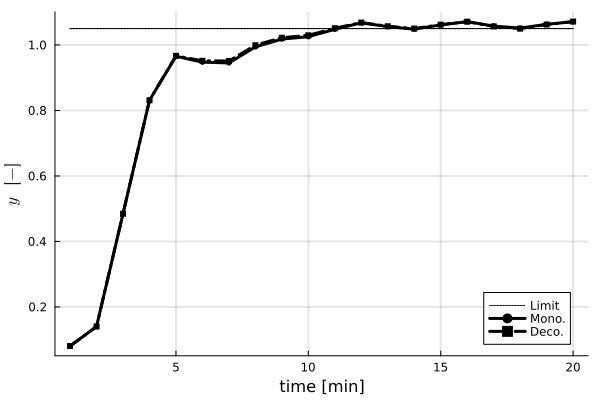

In [29]:
mc_comp(L"y \quad [-]",ts,yMean[:,1,:],(pUB + y0),(pTrack + y0))

Input

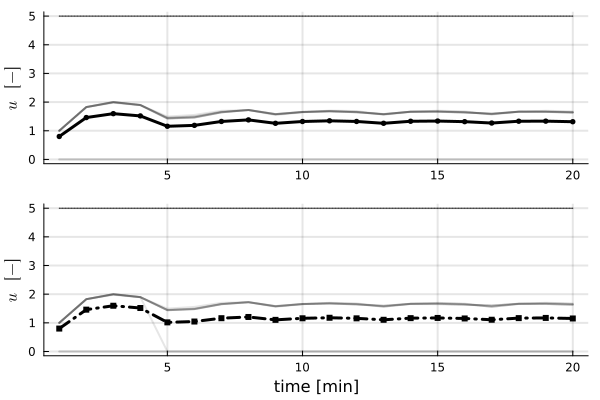

In [24]:
mc_plot(L"u \quad [-]",ts,uMean[:,1,:],uPlant,uMax)

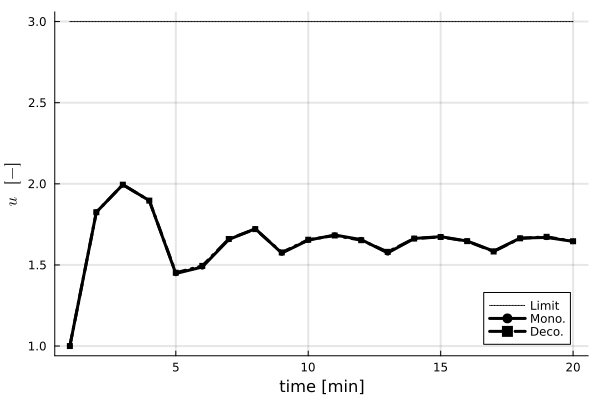

In [31]:
mc_comp(L"u \quad [-]",ts,uMean[:,1,:],3.0)

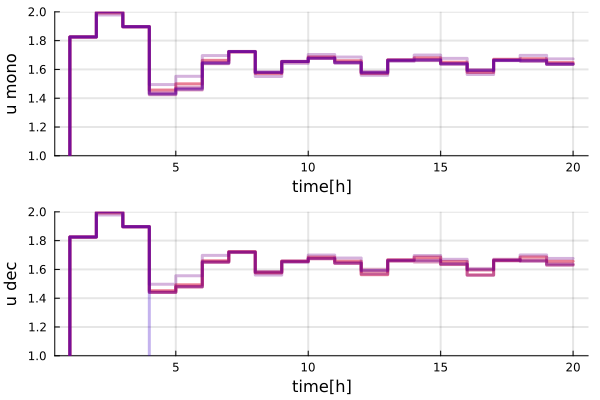

In [26]:
gr()
# limits
p3 = plot(gridlinewidth=2,ylims = (1.0,2.0),yticks = 1.0:0.2:2.0,xaxis="time[h]",yaxis="u mono")

for nn in 1:n_MC
    p3 = plot!(ts,uPlant[:,nn,1],linewidth=3,linetype=:steppre,linealpha = 0.3,linecolor = CList[nn],legend=false)
end

p4 = plot(gridlinewidth=2,ylims = (1.0,2.0),yticks = 1.0:0.2:2.0,xaxis="time[h]",yaxis="u dec")

for nn in 1:n_MC
    p4 = plot!(ts,uPlant[:,nn,2],linewidth=3,linetype=:steppre,linealpha = 0.3,linecolor = CList[nn],legend=false)
end

g2 = plot(p3,p4,layout=(2,1))
display(g2)